# Multi Color Light Curves from Lauren macArthur applied to November/december visits at AuxTel

- author Sylvie Dagoret-Campagne
- creation date 2024-04-04
- last update 2024-04-04
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

 

In [60]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
saveDir = "./lc_output_auxtel_2023_2024_photom"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [3]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 50  # 100

In [4]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
# collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"
#collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985"

collectionStr = collection.replace("/", "_")
instrument = "LATISS"
skymapName = "latiss_v1"

tract = 3864

calibFluxStr = "apFlux_35_0_instFlux"

file_output_selectedsources = f"lightcurves-selectedsources_tract{tract}_2023-2024.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [5]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collection, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LATISS
collection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871


## load isolated_star_sources

In [6]:
# Try to get the Schema
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(i,ref)
    butler_data = butler.get(ref)
    break

if not isinstance(butler_data, pd.core.frame.DataFrame):
    print(butler_data.getSchema())

0 isolated_star_sources@{instrument: 'LATISS', skymap: 'latiss_v1', tract: 383} [sc=DataFrame] (run=LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240206T160257Z id=784d3e58-a02e-4e74-9d48-76b15ff6921c)


## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [7]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [8]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

index            sourceId          visit  detector          ra        dec  \
0    713  178244558356742858  2023111500493         0  122.502819 -36.181372   

    physical_filter band  apFlux_35_0_instFlux  apFlux_35_0_instFluxErr  \
0  empty~SDSSi_65mm    i          18175.596494               576.145944   

             x            y  apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  \
0  3089.041514  3522.968126           18884.53991               812.086676   

   apFlux_50_0_flag  localBackground_instFlux  localBackground_flag  \
0             False                 -0.046051                 False   

   source_row  obj_index  
0         713          0

In [9]:
isolatedStarSourcesFull.head()

index            sourceId          visit  detector          ra        dec  \
0    713  178244558356742858  2023111500493         0  122.502819 -36.181372   
1    755  178244561577968372  2023111500496         0  122.502816 -36.181375   
2    670  178244564799193759  2023111500499         0  122.502820 -36.181372   
3    679  178244568020419240  2023111500502         0  122.502819 -36.181372   
4    576  178244574462870081  2023111500508         0  122.502817 -36.181375   

    physical_filter band  apFlux_35_0_instFlux  apFlux_35_0_instFluxErr  \
0  empty~SDSSi_65mm    i          18175.596494               576.145944   
1  empty~SDSSi_65mm    i          17565.087785               575.726251   
2  empty~SDSSi_65mm    i          18116.303929               589.631325   
3  empty~SDSSi_65mm    i          17729.923577               576.995488   
4  empty~SDSSi_65mm    i          19275.159892               574.297890   

             x            y  apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  \
0  3089.041514  3522.968126          18884.539910               812.086676   
1  2534.640599  3530.208921          17731.305191               812.327495   
2  1981.029109  3539.453433          19207.199949               833.032409   
3  1425.821552  3545.346614          18735.842581               814.675518   
4   315.295535  3562.070830          21449.774805               811.090466   

   apFlux_50_0_flag  localBackground_instFlux  localBackground_flag  \
0             False                 -0.046051                 False   
1             False                  0.076945                 False   
2             False                  0.060362                 False   
3             False                  0.163642                 False   
4             False                  0.462267                 False   

   source_row  obj_index  
0         713          0  
1         755          0  
2         670          0  
3         679          0  
4         576          0

In [10]:
isolatedStarSourcesFull.tail()

index            sourceId          visit  detector          ra  \
152519     55  179546353280483384  2023122200468         0  122.636921   
152520      8  178913118334746633  2023120400546         0  122.627452   
152521    534  179546353280483863  2023122200468         0  122.584535   
152522     18  179300100256825363  2023121500503         0  122.571455   
152523    145  179159378874597522  2023121100518         0  122.371088   

              dec   physical_filter band  apFlux_35_0_instFlux  \
152519 -36.166699  empty~SDSSy_65mm    y           6323.352977   
152520 -36.261952  empty~SDSSy_65mm    y           6154.753825   
152521 -36.077190  empty~SDSSy_65mm    y           6814.557447   
152522 -36.266611  empty~SDSSy_65mm    y           7482.109294   
152523 -36.241104  empty~SDSSy_65mm    y           6187.744941   

        apFlux_35_0_instFluxErr            x            y  \
152519               561.712576  4029.246388   467.715657   
152520               537.923886  3854.589084    69.404199   
152521               566.342704  2482.635397  3855.480970   
152522               647.611675  3342.339900   156.727808   
152523               608.343115   112.746492   984.431644   

        apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
152519                   NaN                      NaN              True   
152520           6039.552589               767.419909             False   
152521           6599.599039               804.355992             False   
152522           9131.216602               923.076524             False   
152523           6689.257230               865.871984             False   

        localBackground_instFlux  localBackground_flag  source_row  obj_index  
152519                 -0.122081                 False          55       1345  
152520                 -0.111863                 False           8       1346  
152521                  0.074439                 False         534       1347  
152522                  0.378480                 False          18       1348  
152523                  0.112740                 False         145       1349

In [11]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [12]:
print(sorted(isolatedStarSourcesFull["visit"].unique()))

[2023111500491, 2023111500492, 2023111500493, 2023111500494, 2023111500495, 2023111500496, 2023111500497, 2023111500498, 2023111500499, 2023111500500, 2023111500501, 2023111500502, 2023111500503, 2023111500504, 2023111500505, 2023111500506, 2023111500507, 2023111500508, 2023111500509, 2023111500510, 2023111500511, 2023111500512, 2023111500513, 2023111500514, 2023111500515, 2023111500516, 2023111500517, 2023111500518, 2023111500519, 2023111500520, 2023111500521, 2023111500522, 2023111500523, 2023111500524, 2023111500525, 2023111500526, 2023111500527, 2023111500528, 2023111500529, 2023111500530, 2023111500531, 2023111500532, 2023111500533, 2023111500534, 2023111500535, 2023111500536, 2023111500537, 2023111500538, 2023111500539, 2023111500540, 2023111500541, 2023111500542, 2023111500543, 2023111500544, 2023111500545, 2023111500546, 2023111500547, 2023111500548, 2023111500549, 2023111500550, 2023111500551, 2023111500552, 2023111500553, 2023111500554, 2023111500555, 2023111500556, 202311150

In [13]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

index            sourceId          visit  detector          ra        dec  \
0    713  178244558356742858  2023111500493         0  122.502819 -36.181372   

    physical_filter band  apFlux_35_0_instFlux  apFlux_35_0_instFluxErr  \
0  empty~SDSSi_65mm    i          18175.596494               576.145944   

             x            y  apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  \
0  3089.041514  3522.968126           18884.53991               812.086676   

   apFlux_50_0_flag  localBackground_instFlux  localBackground_flag  \
0             False                 -0.046051                 False   

   source_row  obj_index  
0         713          0

In [14]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [15]:
calibFluxStr

'apFlux_35_0_instFlux'

In [16]:
minSnCalibFlux

50

In [17]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=40556 matched sources from original 152524)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 365 objects from 1350).


In [18]:
sorted_visitList = sorted(visitList)

In [19]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [20]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [21]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [22]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [23]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 2023111600642
Number of objects with >=3 matches before sourceTable_visit exsistence check: 365
Number of objects with >=3 matches after sourceTable_visit exsistence check: 365


In [24]:
visitsToRemove 

[2023111600642]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [25]:
# need also. ["zeroPoint","airmass"]

In [26]:
# Collect useful columns from ccdVisitTable
ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
    else:
        raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))

In [27]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

visitId   physical_filter band          ra        dec  \
ccdVisitId                                                                 
40919696896  2023051100262  SDSSr_65mm~empty    r  239.946728 -24.053747   

             zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                              
40919696896       56.749516  27.690649  7.814408  11.197219  7.856582   

             astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                 
40919696896          0.026538         0.014041        42   

             psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                
40919696896             -0.007038              0.000486   

             psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                  
40919696896               0.032627               0.014318   

             psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
ccdVisitId                                                     
40919696896                0.107089                 0.110564   

             psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  \
ccdVisitId                                                        
40919696896                       0.013839             0.879543   

             maxDistToNearestPsf   effTime  effTimePsfSigmaScale  \
ccdVisitId                                                         
40919696896          2160.236328  0.207786              0.016376   

             effTimeSkyBgScale  effTimeZeroPointScale       decl  detector  \
ccdVisitId                                                                   
40919696896           2.679237               0.157862 -24.053747         0   

               seeing  skyRotation                   expMidpt   expMidptMJD  \
ccdVisitId                                                                    
40919696896  1.761132   322.911701 2023-05-12 01:08:56.302993  60076.047874   

             expTime                   obsStart  obsStartMJD  darkTime  xSize  \
ccdVisitId                                                                      
40919696896     30.0 2023-05-12 01:08:41.302993   60076.0477   30.2434   4071   

             ySize       llcra     llcdec       ulcra     ulcdec       urcra  \
ccdVisitId                                                                     
40919696896   3999  239.935567 -24.128924  240.029265 -24.062574  239.957876   

                urcdec       lrcra     lrcdec   airmass   medianE  
ccdVisitId                                                         
40919696896 -23.978569  239.864202 -24.044875  1.823818  0.007055

In [28]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [29]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]*dataJoined['psfFlux_apCorr']
dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]*dataJoined['psfFlux_apCorr']

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [30]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  178737263046295565  9.486783e+06  66442.465605         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        0.973419                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  9.406115e+06     74740.013418              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0       125.288936            0.458813                 False     12   

           visit  detector          ra        dec   physical_filter band  \
0  2023112900608         0  122.442392 -36.177752  empty~SDSSy_65mm    y   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x           y  \
0          77932.937467               903.385434  1222.474595  161.781423   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0          77984.425818              1260.907649             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                 -0.272746                 False          12        519   

        psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
0  142.781929  13.957203   0.007604         9.504592e+06   

   apFlux_35_0_calFluxErr  psfInstMag  psfGausFluxRatio  psfSigma      skyBg  \
0           110175.627209   19.201984          1.008576  5.135229  81.539711   

   expTime   expMidptMjd  nSource   medianE  psfStarScaledDeltaSizeScatter  \
0     30.0  60278.317599      501  0.002886                       0.019666   

   astromOffsetStd  psfTraceRadiusDelta  zeroPoint   airmass  
0         0.006935             0.702054  26.160454  1.016643

## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [31]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [32]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  178737263046295565  9.486783e+06  66442.465605         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        0.973419                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  9.406115e+06     74740.013418              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0       125.288936            0.458813                 False     12   

           visit  detector          ra        dec   physical_filter band  \
0  2023112900608         0  122.442392 -36.177752  empty~SDSSy_65mm    y   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x           y  \
0          77932.937467               903.385434  1222.474595  161.781423   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0          77984.425818              1260.907649             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                 -0.272746                 False          12        519   

        psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
0  142.781929  13.957203   0.007604         9.504592e+06   

   apFlux_35_0_calFluxErr  psfInstMag  psfGausFluxRatio  psfSigma      skyBg  \
0           110175.627209   19.201984          1.008576  5.135229  81.539711   

   expTime   expMidptMjd  nSource   medianE  psfStarScaledDeltaSizeScatter  \
0     30.0  60278.317599      501  0.002886                       0.019666   

   astromOffsetStd  psfTraceRadiusDelta  zeroPoint   airmass  psfMagDiffMmag  \
0         0.006935             0.702054  26.160454  1.016643    -1407.574892   

   psfMagDiffChi  raDiffMas  decDiffMas  raCosDecDiffMas  
0     -29.189194  -2.745807    0.206585         -2.39607

In [33]:
dataJoined.head()

sourceId       psfFlux     psfFluxErr  psfFlux_flag  \
0  178737263046295565  9.486783e+06   66442.465605         False   
1  178737263046295600  2.675225e+07  127323.422540         False   
2  178737263046295656  9.062566e+06   63904.753768         False   
3  178737263046295689  3.582970e+07  157924.685864         False   
4  178737263046295766  8.228273e+06   62810.320165         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        0.973419                0.0           0.0              True   
1        1.000505                0.0           0.0              True   
2        1.013909                0.0           0.0              True   
3        1.008531                0.0           0.0              True   
4        0.998891                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  9.406115e+06     74740.013418              False   
1             True  2.675853e+07    141684.217160              False   
2            False  9.065810e+06     73692.840408              False   
3             True  3.568410e+07    171801.034380              False   
4            False  8.283156e+06     71878.564820              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0       125.288936            0.458813                 False     12   
1       125.563844            0.458813                 False     47   
2       127.356055            0.458813                 False    103   
3       126.921173            0.458813                 False    136   
4       125.153379            0.458813                 False    213   

           visit  detector          ra        dec   physical_filter band  \
0  2023112900608         0  122.442392 -36.177752  empty~SDSSy_65mm    y   
1  2023112900608         0  122.476595 -36.168951  empty~SDSSy_65mm    y   
2  2023112900608         0  122.515907 -36.156007  empty~SDSSy_65mm    y   
3  2023112900608         0  122.512653 -36.148488  empty~SDSSy_65mm    y   
4  2023112900608         0  122.476706 -36.132519  empty~SDSSy_65mm    y   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x            y  \
0          77932.937467               903.385434  1222.474595   161.781423   
1         217983.185204               977.772048  2265.324369   479.543523   
2          74809.829195               817.849694  3465.721019   950.680846   
3         285728.158457               930.479046  3370.720402  1234.814136   
4          65080.452301               891.373417  2286.768129  1849.876254   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0          77984.425818              1260.907649             False   
1         228790.634424              1322.997311             False   
2          82397.644352              1140.336058             False   
3         296625.891897              1229.337179             False   
4          64346.872818              1247.932736             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                 -0.272746                 False          12        519   
1                  1.393337                 False          47        120   
2                  1.264186                 False         103        417   
3                  1.786971                 False         136       1219   
4                 -0.194959                 False         213         88   

        psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
0  142.781929  13.957203   0.007604         9.504592e+06   
1  210.112563  12.831599   0.005167         2.738462e+07   
2  141.813648  14.006872   0.007656         9.660004e+06   
3  226.878408  12.514392   0.004786         3.657431e+07   
4  131.001935  14.111728   0.008288         8.136005e+06   

   apFlux_35_0_calFluxErr  psfInstMag  psfGausFluxRatio  psfSigma      skyBg  \
0           110175.627209   19.201984          1.008576  5.135229 

## Check the correlation between the flux psf and apperture flux

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [34]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux","apFlux_35_0_calFlux", "apFlux_35_0_instFlux","psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr","apFlux_35_0_calFluxErr", "apFlux_35_0_instFluxErr","skyBg"]]

In [35]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

obj_index            sourceId band          visit          ra  \
3627           3  178244564799193809    i  2023111500499  122.487002   
3713           3  178244568020419298    i  2023111500502  122.487000   
3973           3  178244577684095401    i  2023111500511  122.486999   
4064           3  178244580905320961    i  2023111500514  122.487002   
4157           3  178244584126546385    i  2023111500517  122.487006   
...          ...                 ...  ...            ...         ...   
16512       1335  180918176572244248    y  2024013000126  122.532817   
14042       1337  178455686064111636    y  2023112100513  122.519842   
14137       1337  178455690359078933    y  2023112100517  122.519841   
709         1337  179300091666890767    y  2023121500495  122.519841   
771         1337  179300100256825355    y  2023121500503  122.519844   

             dec     psfMag       psfFlux  gaussianFlux  apFlux_35_0_calFlux  \
3627  -36.174439  15.973768  1.480787e+06  1.475287e+06         1.543236e+06   
3713  -36.174442  16.028515  1.407972e+06  1.442412e+06         1.419635e+06   
3973  -36.174438  16.038598  1.394957e+06  1.387286e+06         1.370599e+06   
4064  -36.174440  16.032871  1.402335e+06  1.405274e+06         1.410380e+06   
4157  -36.174438  16.035666  1.398729e+06  1.383478e+06         1.354422e+06   
...          ...        ...           ...           ...                  ...   
16512 -36.107706  11.138902  1.271860e+08  1.258804e+08         1.303358e+08   
14042 -36.268801  11.944056  6.058675e+07  6.191232e+07         6.268777e+07   
14137 -36.268803  12.003591  5.735398e+07  5.689391e+07         5.929001e+07   
709   -36.268800  11.928550  6.145821e+07  6.136256e+07         6.207968e+07   
771   -36.268799  11.907988  6.263321e+07  6.283706e+07         6.382830e+07   

       apFlux_35_0_instFlux  psfFlux_apCorr  psfMagErr     psfFluxErr  \
3627           5.900301e+04        1.053587   0.006727    9174.771800   
3713           5.682366e+04        1.013461   0.006890    8934.238590   
3973           5.598316e+04        0.997296   0.006619    8504.078947   
4064           5.813187e+04        0.987165   0.006474    8361.684229   
4157           5.669590e+04        0.979838   0.006539    8424.212872   
...                     ...             ...        ...            ...   
16512          1.028325e+06        1.023883   0.003434  402289.670956   
14042          4.949681e+05        1.028192   0.002934  163743.297035   
14137          4.980361e+05        1.012194   0.003568  188464.975351   
709            4.730180e+05        1.012759   0.004383  248119.677229   
771            4.855444e+05        1.008720   0.003445  198754.402572   

       gaussianFluxErr  apFlux_35_0_calFluxErr  apFlux_35_0_instFluxErr  \
3627      10776.886433            15964.919232               610.391649   
3713      10169.828165            15400.443083               616.432562   
3973      10353.695005            14135.796180               577.387507   
4064      10245.094248            14741.157721               607.588603   
4157      10113.928029            14434.813651               604.239253   
...                ...                     ...                      ...   
16512    413632.404839           146898.462430              1159.001342   
14042    194136.522899           117890.222543               930.833803   
14137    203902.608720           109855.297824               922.784455   
709      259481.114688           120242.633659               916.192315   
771      215067.514323           117663.537369               895.071159   

           skyBg  
3627   12.010967  
3713   12.466047  
3973   11.956738  
4064   11.736943  
4157   11.306849  
...          ...  
16512  12.037750  
14042  12.306285  
14137  12.448900  
709    11.359197  
771    11.279590  

[40548 rows x 18 columns]

In [36]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

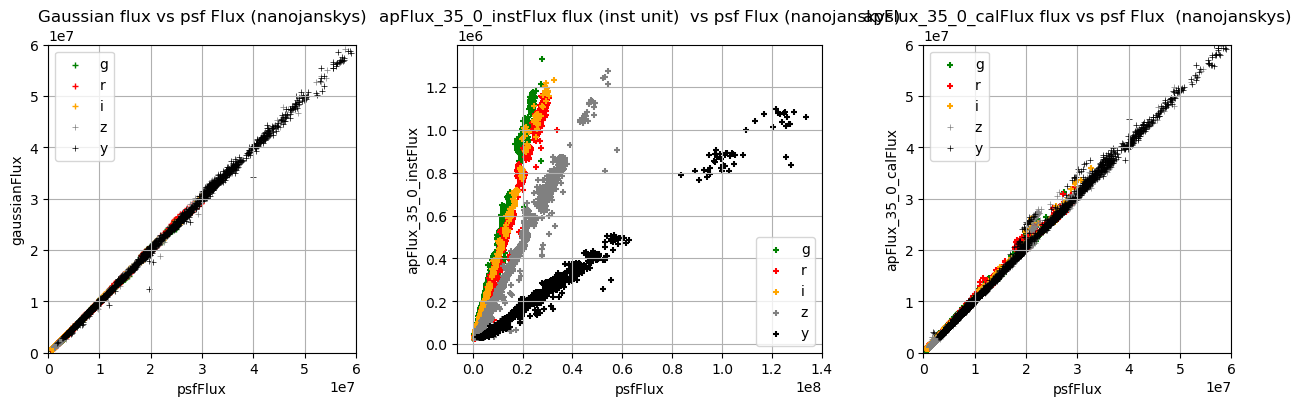

In [37]:
fig,axs = plt.subplots(1,3,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
ax.set_xlim(0.,0.6e8)
ax.set_ylim(0.,0.6e8)
ax.set_title("Gaussian flux vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="grey",marker="+",label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="k",marker="+",label="y")
ax.set_aspect("auto")
ax.set_title("apFlux_35_0_instFlux flux (inst unit)  vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[2]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
ax.set_xlim(0.,0.6e8)
ax.set_ylim(0.,0.6e8)
ax.set_title("apFlux_35_0_calFlux flux vs psf Flux  (nanojanskys)")
ax.grid()


Text(0.5, 0.98, 'All selected sources')

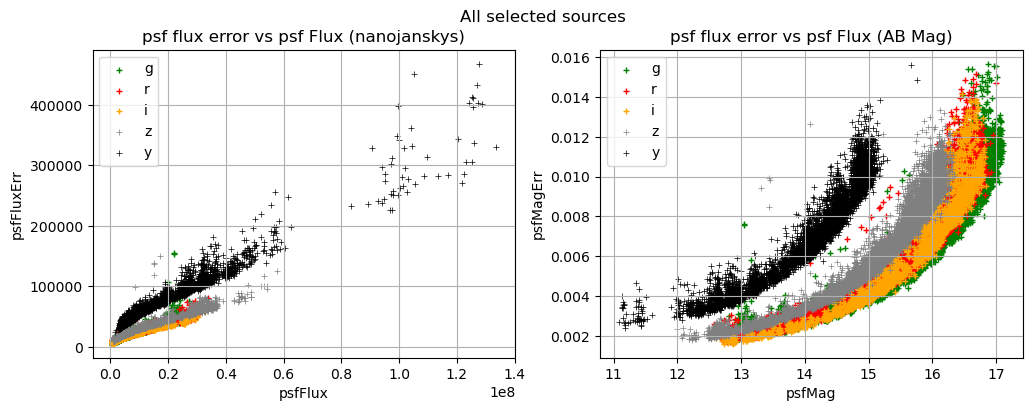

In [38]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (AB Mag)")
ax.grid()

plt.suptitle("All selected sources")

## Statistics on Light Curves

- want number of source per object

In [39]:
#my_list = list(dataJoined.columns)
#for name in my_list:
#    print(name)

#### Compute pandas series with multi-label or series per color 

In [40]:
count_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).count()["visit"]
size_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).size()
count_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).count()["sourceId"]
size_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).size()
size_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).size()
size_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).size()
size_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).size()
size_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).size()

Text(0.5, 0.98, 'number of sources per object')

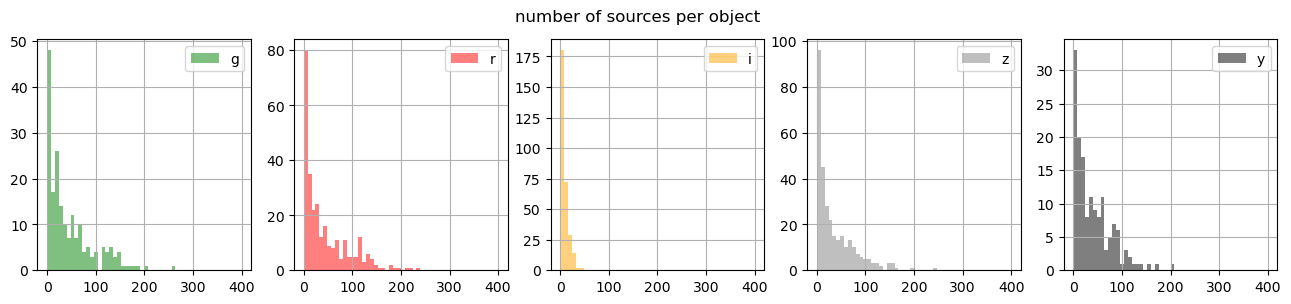

In [41]:
fig,axs = plt.subplots(1,5,figsize=(16,3))
ax=axs[0]
size_source_visit_g.hist(bins=50,range=(0,400.),ax=ax,facecolor="g",alpha=0.5,label="g")
ax.legend()
ax=axs[1]
size_source_visit_r.hist(bins=50,range=(0,400.),ax=ax,facecolor="r",alpha=0.5,label="r")
ax.legend()
ax=axs[2]
size_source_visit_i.hist(bins=50,range=(0,400.),ax=ax,facecolor="orange",alpha=0.5,label="i")
ax.legend()
ax=axs[3]
size_source_visit_z.hist(bins=50,range=(0,400.),ax=ax,facecolor="grey",alpha=0.5,label="z")
ax.legend()
ax=axs[4]
size_source_visit_y.hist(bins=50,range=(0,400.),ax=ax,facecolor="k",alpha=0.5,label="y")
ax.legend()

plt.suptitle("number of sources per object")

In [42]:
#count_source_visit[3,"r"]

### Filtering the object using pandas series and dataframe

#### Unstacking a multi-label pandas series into a dataframe

In [43]:
NMIN = 20. # minimum number of visit in Y band
NBANDMIN = 4 # nimimum number of bands

In [44]:
size_source_visit 

obj_index  band
3          i        44
           r         3
           z       241
6          g         5
           i        42
                  ... 
1330       g         1
           y         2
1334       y        24
1335       y        18
1337       y         4
Length: 1234, dtype: int64

#### Select the object having at least NYMIN visit in band Y

- however it is useless, the selection will be done on pandas dataframe from unstacked series

In [45]:
cut_NY = size_source_visit[:,'y']  >= NMIN
cut_NY

obj_index
27       True
38       True
43       True
50      False
62       True
        ...  
1309    False
1330    False
1334     True
1335    False
1337    False
Length: 150, dtype: bool

In [46]:
size_source_visit_unstacked = size_source_visit.unstack()
size_source_visit_unstacked 

band          g     i      r     y      z
obj_index                                
3           NaN  44.0    3.0   NaN  241.0
6           5.0  42.0  212.0   NaN  159.0
9           NaN  10.0    NaN   NaN    NaN
10         80.0  38.0  178.0   NaN   38.0
12          NaN  13.0    NaN   NaN    NaN
...         ...   ...    ...   ...    ...
1319       52.0   NaN    NaN   NaN    NaN
1330        1.0   NaN    NaN   2.0    NaN
1334        NaN   NaN    NaN  24.0    NaN
1335        NaN   NaN    NaN  18.0    NaN
1337        NaN   NaN    NaN   4.0    NaN

[365 rows x 5 columns]

#### Apply the selection on the pandas series

In [47]:
cut_on_size_in_bands = (size_source_visit_unstacked.y>= NMIN) & (size_source_visit_unstacked.g>= NMIN) & (size_source_visit_unstacked.r>= NMIN) & (size_source_visit_unstacked.z>= NMIN) 

size_source_visit_unstacked = size_source_visit_unstacked[cut_on_size_in_bands ] 
size_source_visit_unstacked

band           g     i      r      y      z
obj_index                                  
27         190.0  31.0  190.0   20.0  160.0
62         256.0  24.0  239.0  201.0  121.0
77         126.0  22.0  101.0   86.0   51.0
81         150.0  22.0  148.0   88.0  132.0
87         129.0  21.0  136.0   56.0  111.0
88         145.0  21.0  141.0  133.0   93.0
90         114.0  21.0  119.0   89.0  101.0
93         123.0  21.0  116.0   88.0   89.0
96         132.0  20.0  134.0   33.0  116.0
108        145.0  19.0  133.0  103.0  107.0
120        128.0  18.0  107.0   56.0   91.0
128        143.0  18.0  116.0   86.0   71.0
146        136.0  16.0   65.0   59.0   29.0
149        113.0  16.0  120.0  112.0  101.0
157         62.0  15.0   61.0   33.0   40.0
163         89.0  15.0   86.0  108.0   77.0
170         98.0  14.0   98.0  110.0   79.0
180         96.0  14.0   83.0   83.0   75.0
217         66.0  12.0   57.0   57.0   60.0
221        121.0  12.0   90.0  112.0   66.0
247         83.0  11.0   85.0   81.0   70.0
278         56.0  10.0   54.0   54.0   48.0
341         70.0   8.0   68.0   60.0   58.0
350        100.0   8.0   85.0   63.0   34.0
351         74.0   8.0   71.0   67.0   54.0
367         92.0   8.0   83.0   89.0   82.0
384         86.0   8.0   88.0   83.0   81.0
401         49.0   7.0   45.0   51.0   47.0
417        139.0   7.0  100.0   53.0   26.0
452         56.0   6.0   47.0   55.0   20.0
459         51.0   6.0   47.0   44.0   39.0
469         69.0   6.0   51.0   63.0   43.0
489         48.0   6.0   42.0   44.0   31.0
516         23.0   5.0   23.0   23.0   21.0
520         38.0   5.0   37.0   41.0   36.0
547         55.0   4.0   43.0   27.0   27.0
573         44.0   4.0   37.0   24.0   32.0
579         40.0   4.0   40.0   37.0   40.0
584         31.0   4.0   28.0   35.0   29.0
589         24.0   4.0   28.0   70.0   43.0
602         25.0   3.0   23.0   26.0   23.0
612         46.0   3.0   38.0   38.0   32.0
642         45.0   3.0   41.0   42.0   28.0
672         32.0   3.0   33.0   34.0   33.0
677         57.0   3.0   48.0   55.0   51.0
693         77.0   2.0   33.0   76.0   28.0
714         30.0   2.0   28.0   41.0   35.0
737         21.0   2.0   22.0   29.0   28.0
803         59.0   2.0   59.0   72.0   59.0
857         31.0   1.0   31.0   25.0   23.0
1004        66.0   1.0   70.0   83.0   78.0
1025        29.0   1.0   27.0   25.0   31.0
1034        67.0   NaN   56.0  120.0   79.0

In [48]:
len(size_source_visit_unstacked)

53

#### Dropping the object not having a visit in all bands on the pandas dataframe from unstacked series

In [49]:
size_source_visit_selected =size_source_visit_unstacked.dropna(axis=0,how='any') 
size_source_visit_selected

band           g     i      r      y      z
obj_index                                  
27         190.0  31.0  190.0   20.0  160.0
62         256.0  24.0  239.0  201.0  121.0
77         126.0  22.0  101.0   86.0   51.0
81         150.0  22.0  148.0   88.0  132.0
87         129.0  21.0  136.0   56.0  111.0
88         145.0  21.0  141.0  133.0   93.0
90         114.0  21.0  119.0   89.0  101.0
93         123.0  21.0  116.0   88.0   89.0
96         132.0  20.0  134.0   33.0  116.0
108        145.0  19.0  133.0  103.0  107.0
120        128.0  18.0  107.0   56.0   91.0
128        143.0  18.0  116.0   86.0   71.0
146        136.0  16.0   65.0   59.0   29.0
149        113.0  16.0  120.0  112.0  101.0
157         62.0  15.0   61.0   33.0   40.0
163         89.0  15.0   86.0  108.0   77.0
170         98.0  14.0   98.0  110.0   79.0
180         96.0  14.0   83.0   83.0   75.0
217         66.0  12.0   57.0   57.0   60.0
221        121.0  12.0   90.0  112.0   66.0
247         83.0  11.0   85.0   81.0   70.0
278         56.0  10.0   54.0   54.0   48.0
341         70.0   8.0   68.0   60.0   58.0
350        100.0   8.0   85.0   63.0   34.0
351         74.0   8.0   71.0   67.0   54.0
367         92.0   8.0   83.0   89.0   82.0
384         86.0   8.0   88.0   83.0   81.0
401         49.0   7.0   45.0   51.0   47.0
417        139.0   7.0  100.0   53.0   26.0
452         56.0   6.0   47.0   55.0   20.0
459         51.0   6.0   47.0   44.0   39.0
469         69.0   6.0   51.0   63.0   43.0
489         48.0   6.0   42.0   44.0   31.0
516         23.0   5.0   23.0   23.0   21.0
520         38.0   5.0   37.0   41.0   36.0
547         55.0   4.0   43.0   27.0   27.0
573         44.0   4.0   37.0   24.0   32.0
579         40.0   4.0   40.0   37.0   40.0
584         31.0   4.0   28.0   35.0   29.0
589         24.0   4.0   28.0   70.0   43.0
602         25.0   3.0   23.0   26.0   23.0
612         46.0   3.0   38.0   38.0   32.0
642         45.0   3.0   41.0   42.0   28.0
672         32.0   3.0   33.0   34.0   33.0
677         57.0   3.0   48.0   55.0   51.0
693         77.0   2.0   33.0   76.0   28.0
714         30.0   2.0   28.0   41.0   35.0
737         21.0   2.0   22.0   29.0   28.0
803         59.0   2.0   59.0   72.0   59.0
857         31.0   1.0   31.0   25.0   23.0
1004        66.0   1.0   70.0   83.0   78.0
1025        29.0   1.0   27.0   25.0   31.0

#### Restack the pandas dataframe into a pandas series with multi-label

In [50]:
ser_size_source_visit_selected = size_source_visit_selected.stack()
ser_size_source_visit_selected 

obj_index  band
27         g       190.0
           i        31.0
           r       190.0
           y        20.0
           z       160.0
                   ...  
1025       g        29.0
           i         1.0
           r        27.0
           y        25.0
           z        31.0
Length: 260, dtype: float64

#### Extract the list of selected objects from the pandas dataframe (from unstacked series)

In [51]:
selected_objects_indexes = list(size_source_visit_selected.index)
print("Nobj = ",len(selected_objects_indexes),"::",selected_objects_indexes )

Nobj =  52 :: [27, 62, 77, 81, 87, 88, 90, 93, 96, 108, 120, 128, 146, 149, 157, 163, 170, 180, 217, 221, 247, 278, 341, 350, 351, 367, 384, 401, 417, 452, 459, 469, 489, 516, 520, 547, 573, 579, 584, 589, 602, 612, 642, 672, 677, 693, 714, 737, 803, 857, 1004, 1025]


In [52]:
#ser_size_source_visit_selected.keys() 

#### Loop on keys multi-label in pandas series

In [53]:
#for name,group in dataJoined_subset.groupby(by=["obj_index","band"]):
#    print("name = ",name)
#    print("group = ",group["visitId"])

In [54]:
#for (idx,band),val in count_source_visit:
#    print(idx,band,val)

### Plot the SED with psf Flux

190


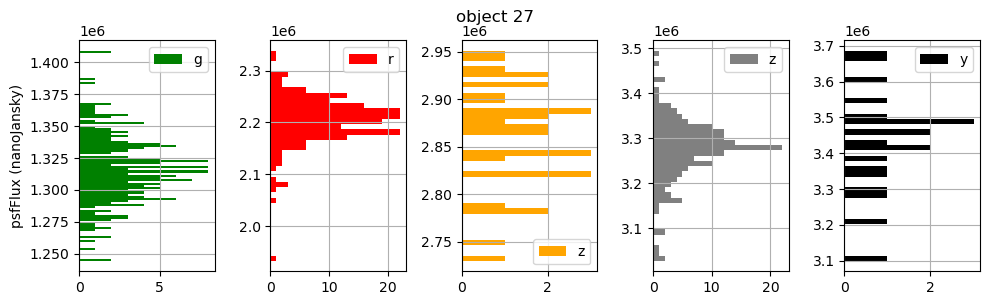

256


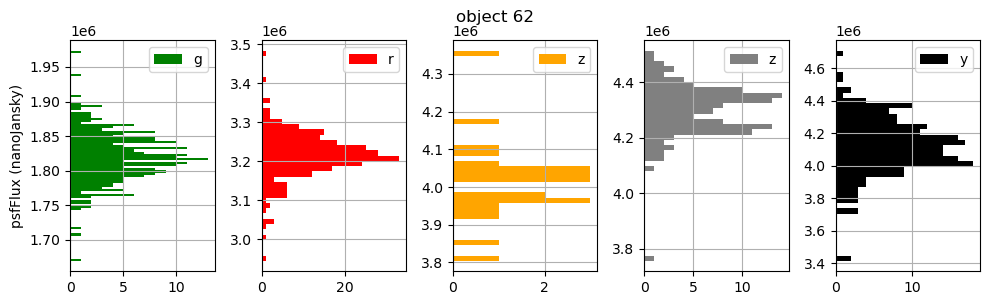

126


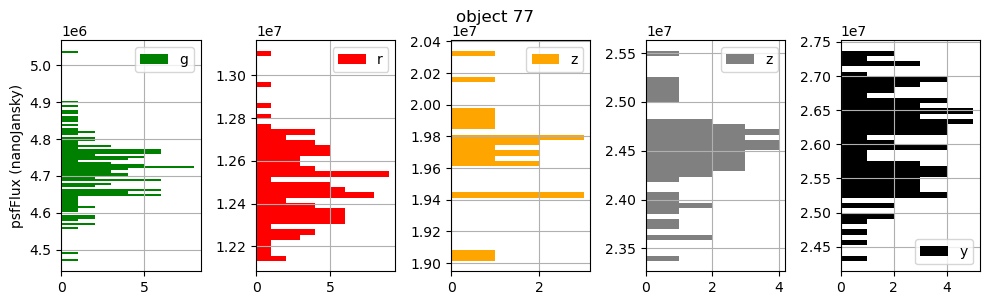

150


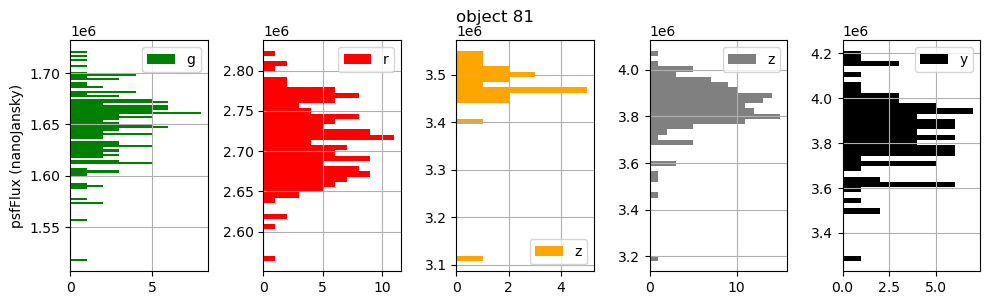

129


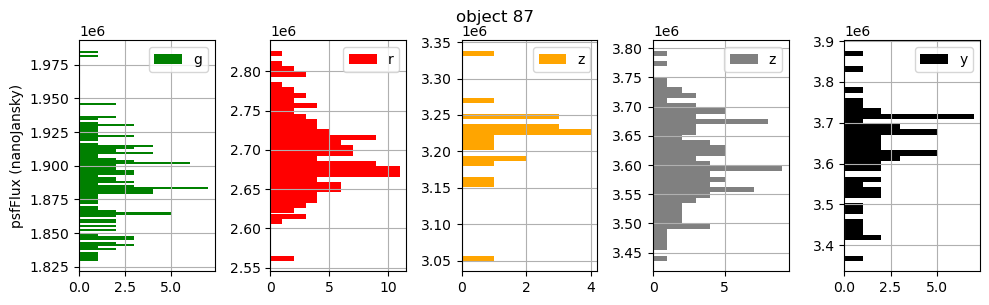

145


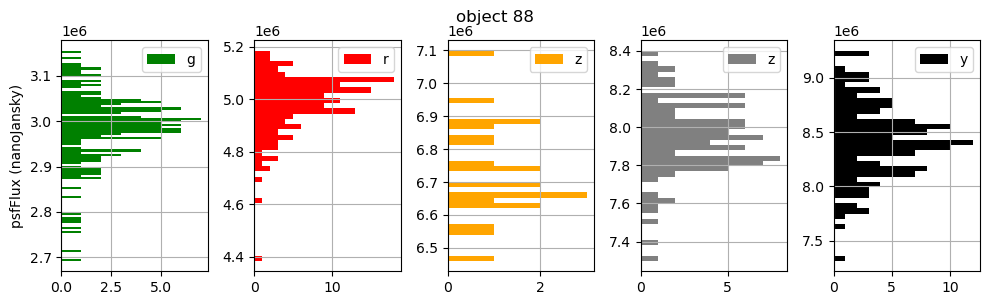

114


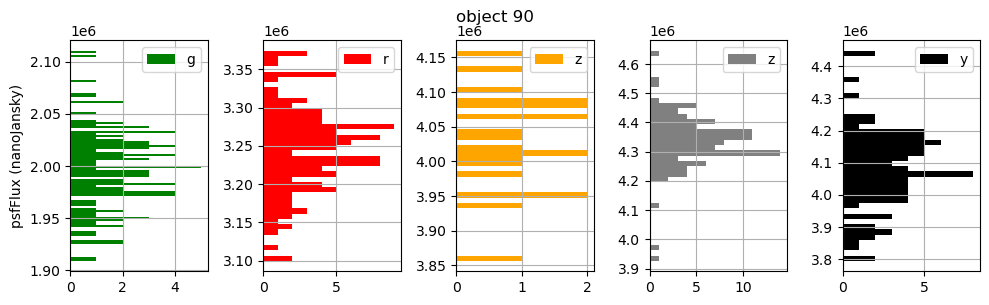

123


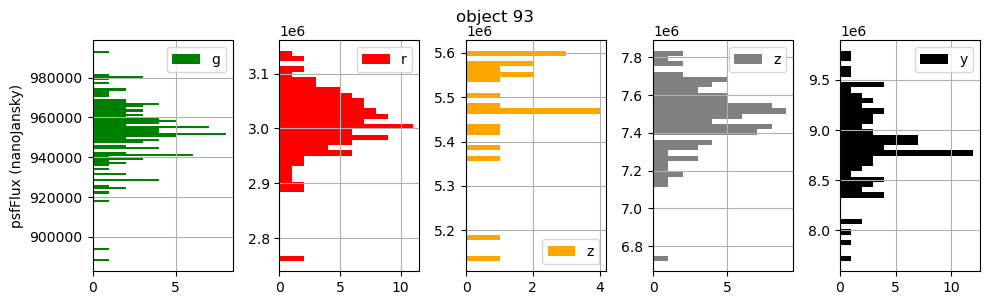

132


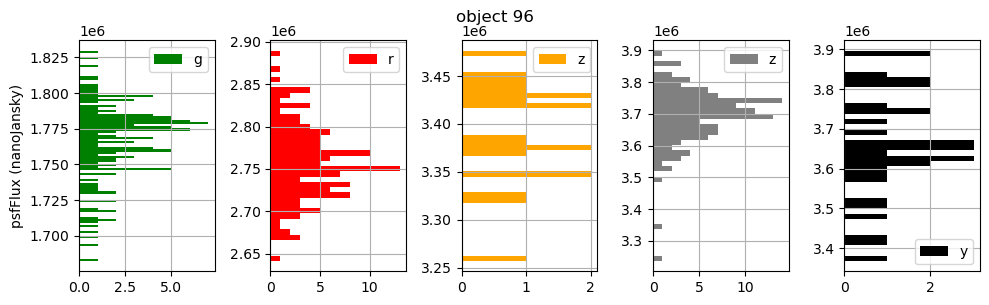

145


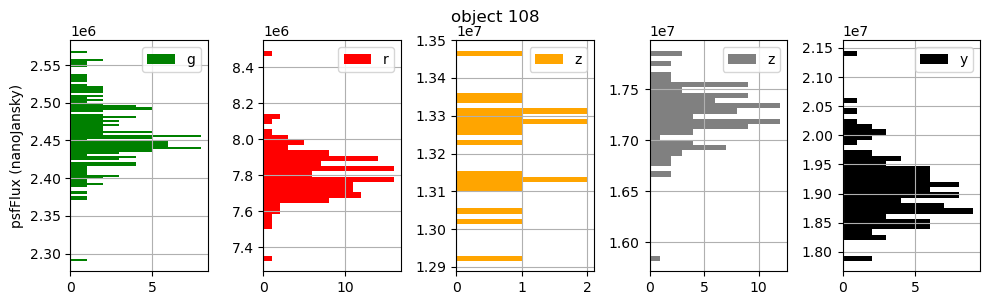

128


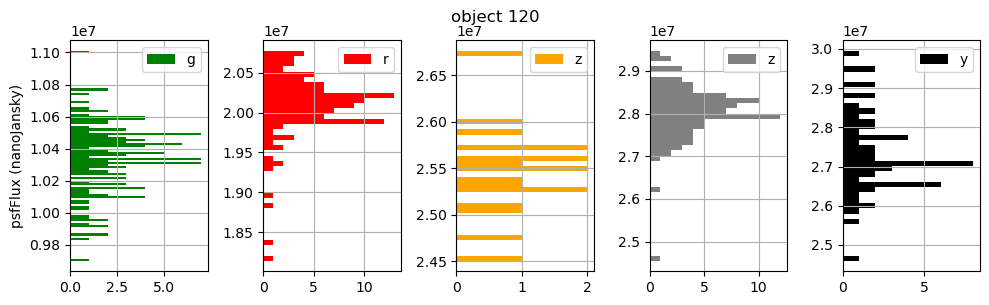

143


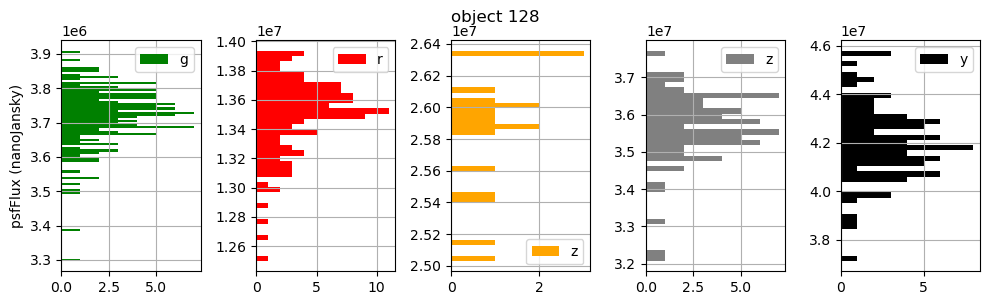

136


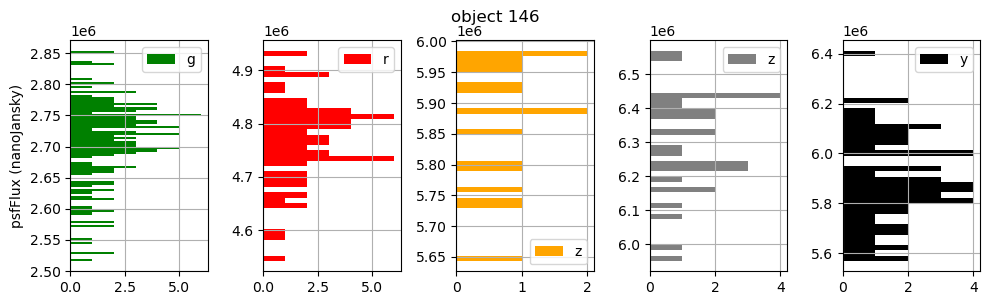

113


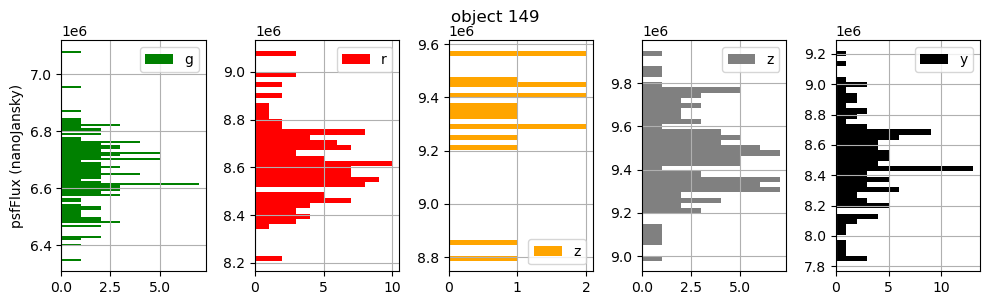

62


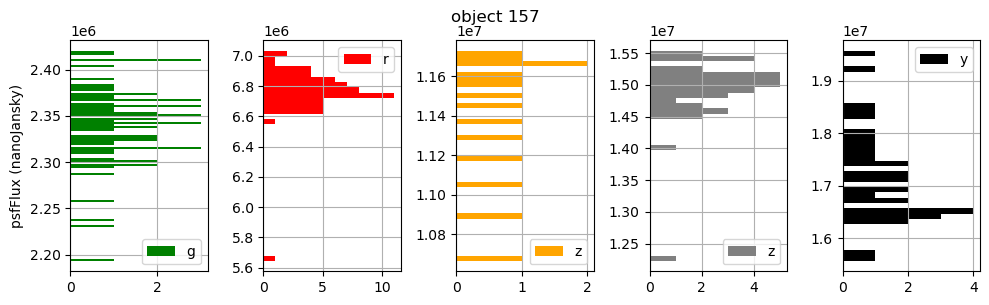

89


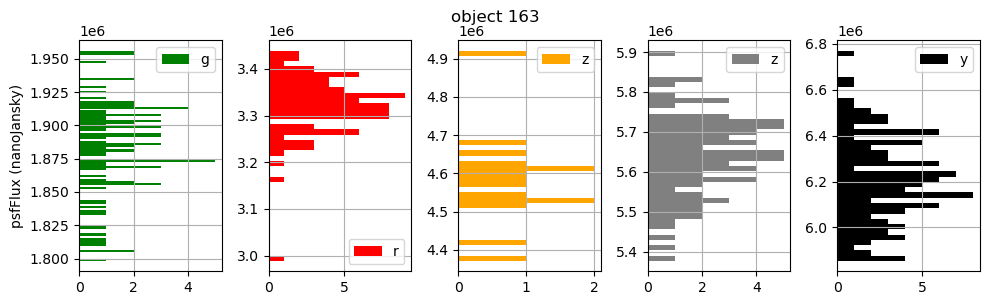

98


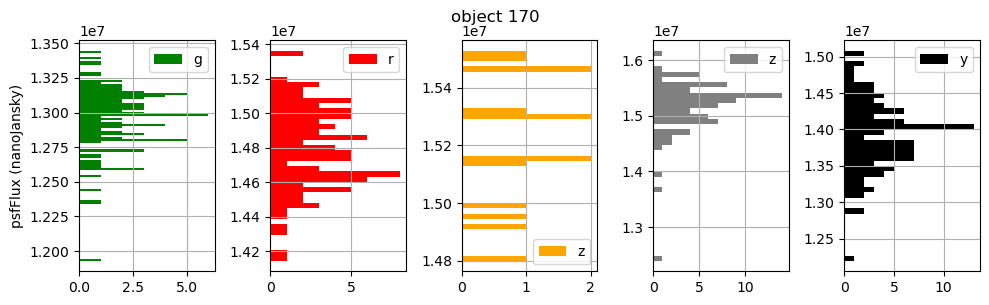

96


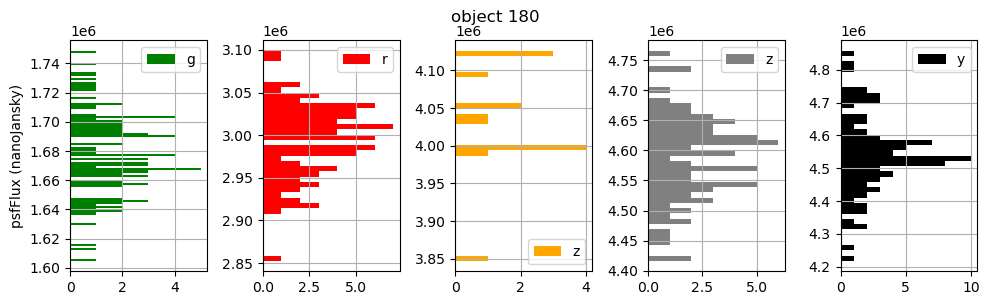

66


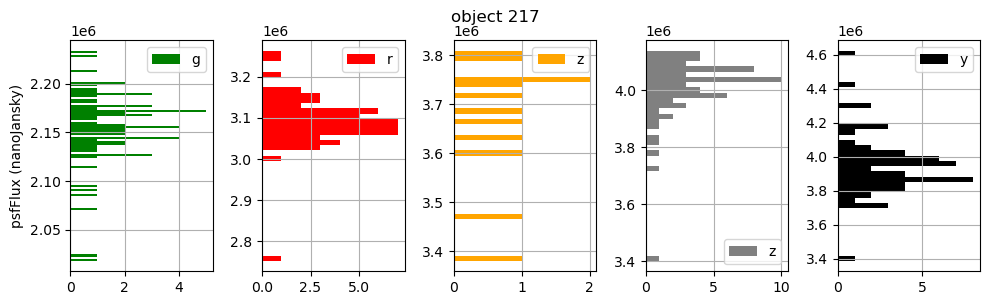

121


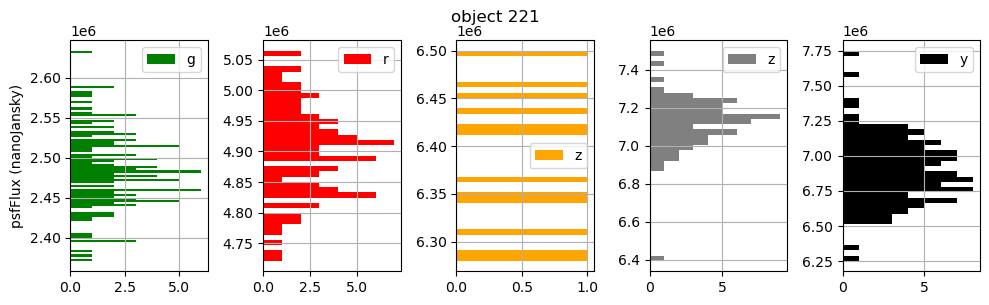

83


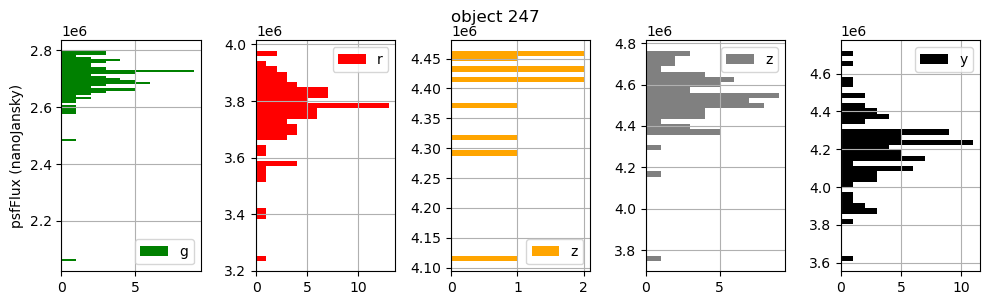

56


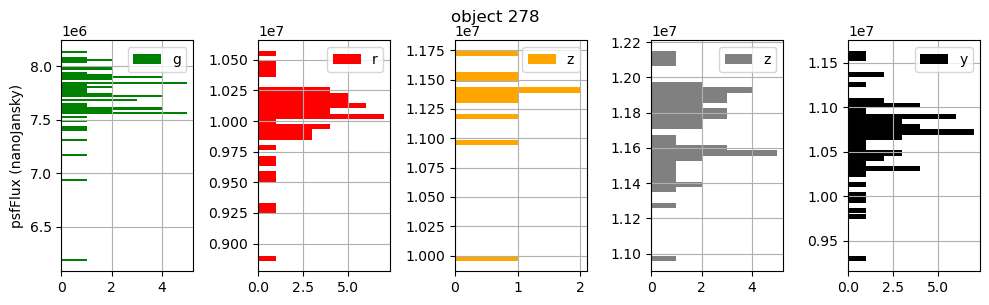

70


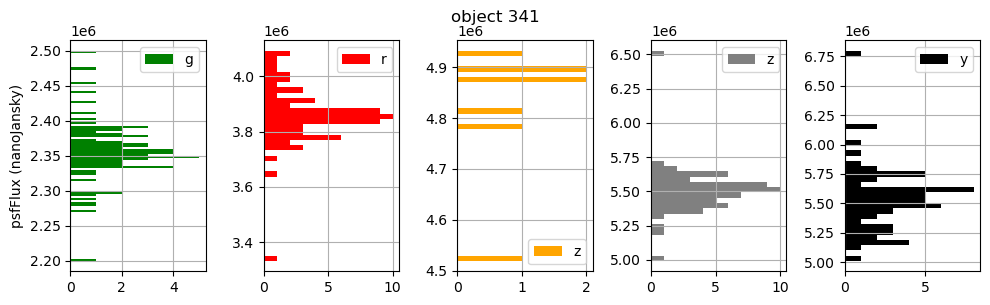

100


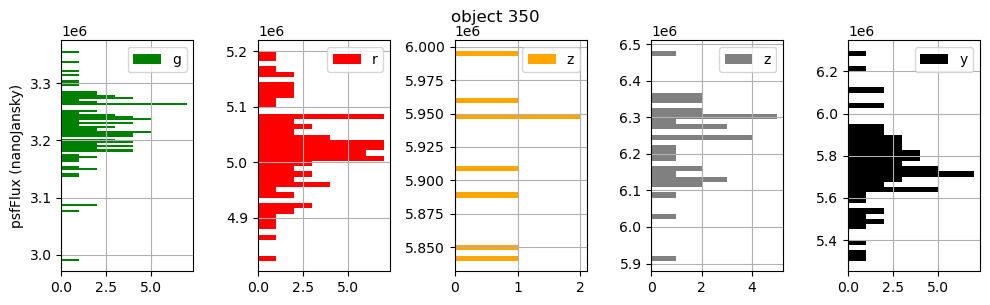

74


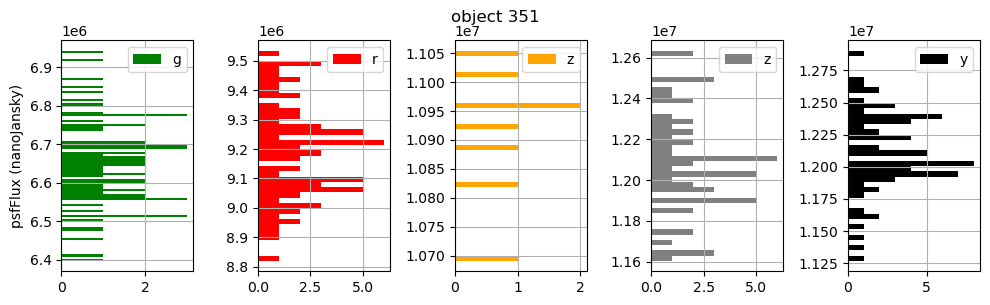

92


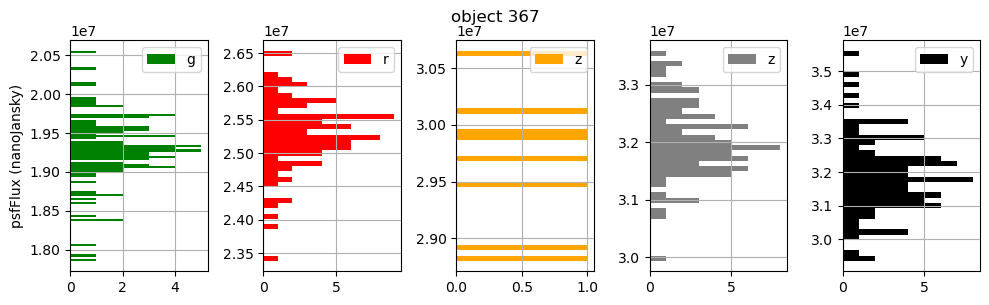

86


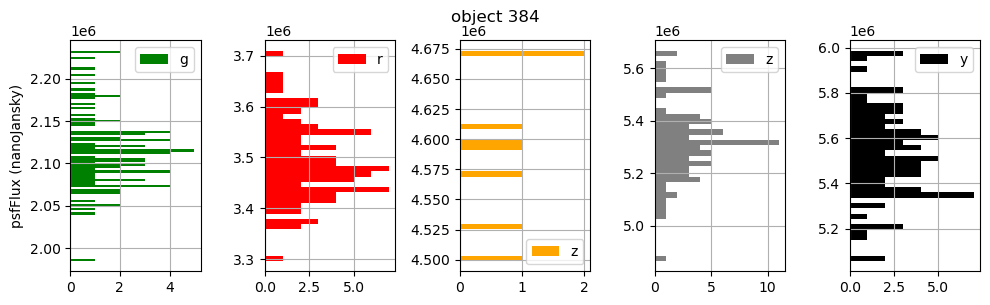

49


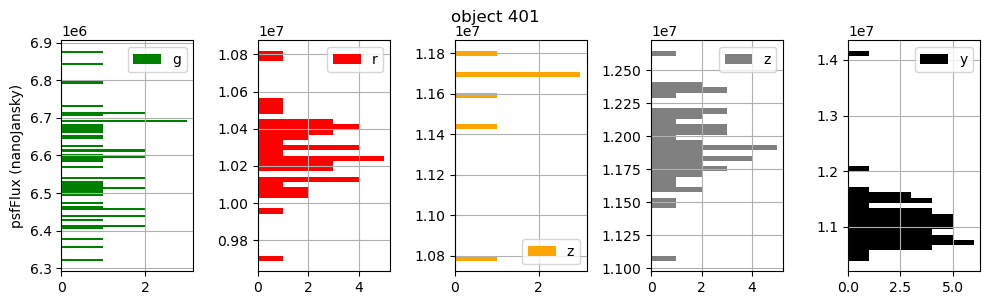

139


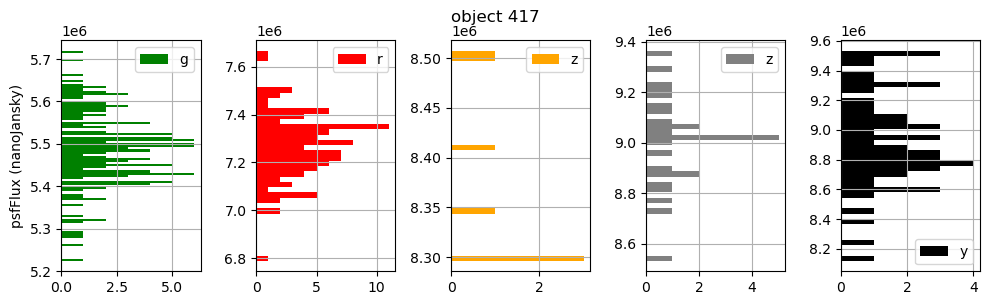

56


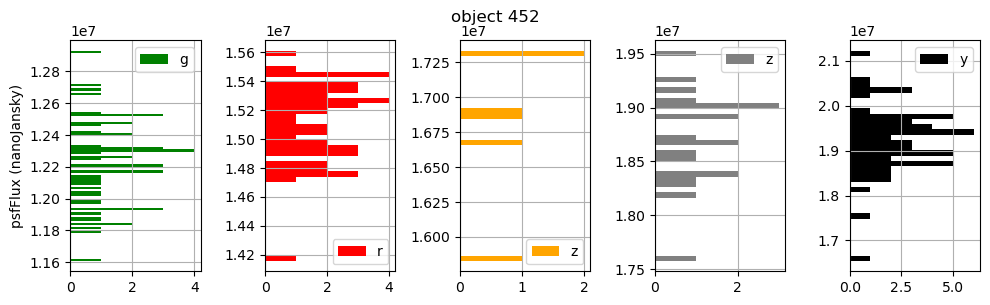

51


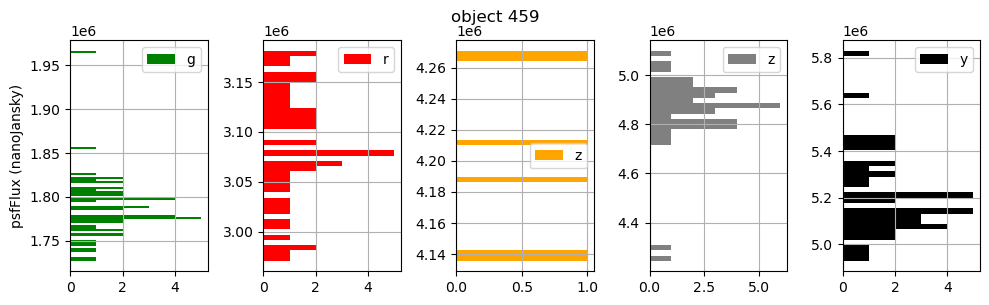

69


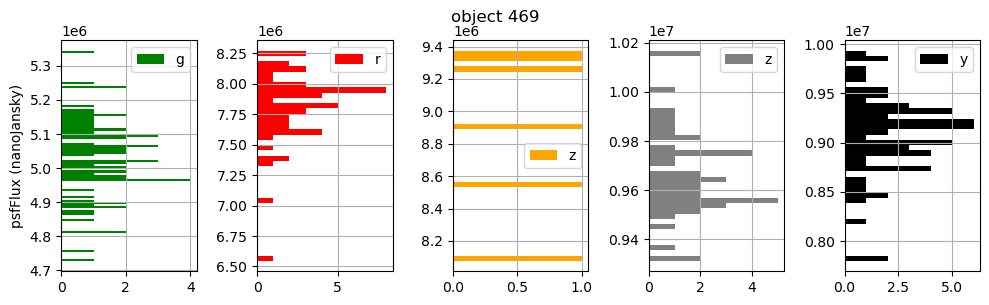

48


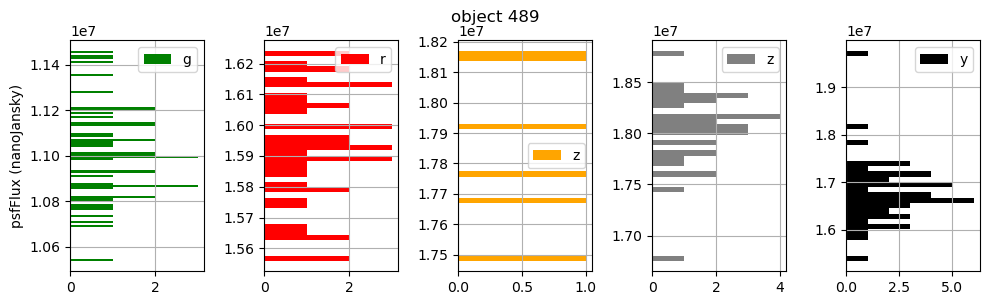

23


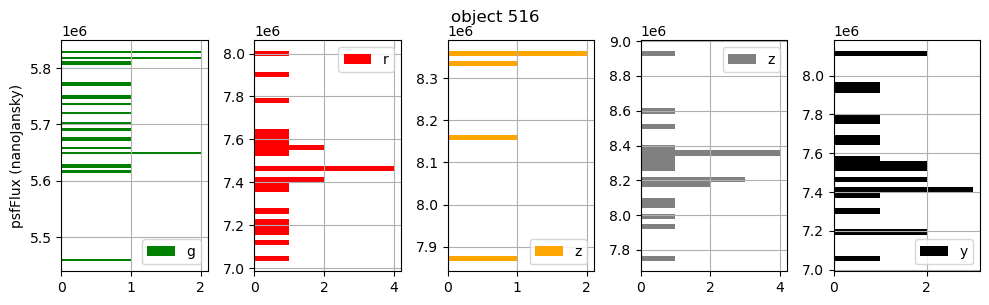

38


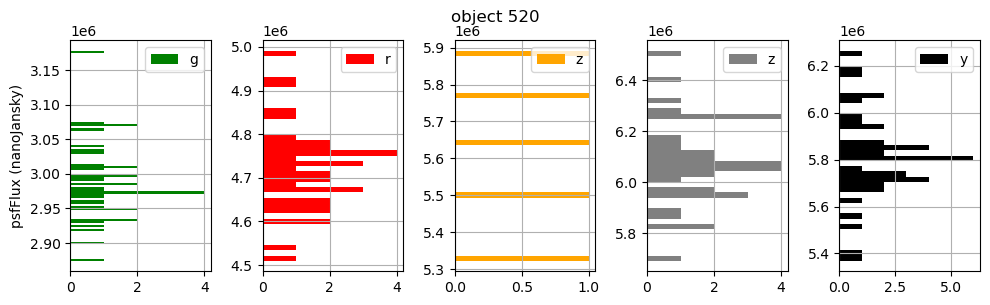

55


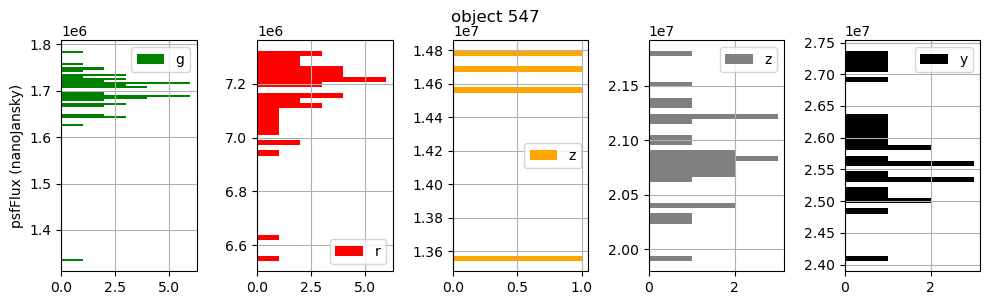

44


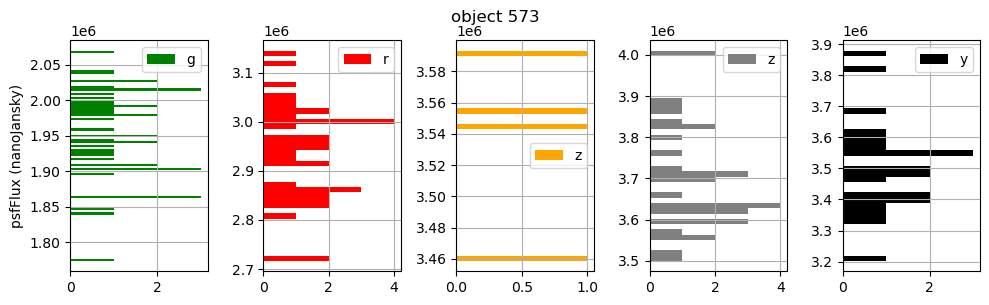

40


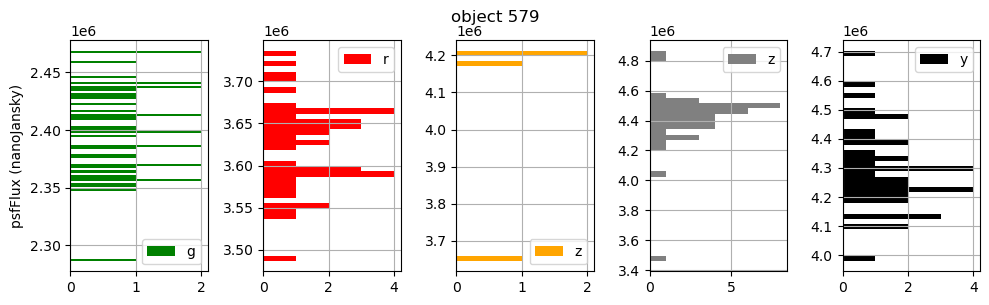

31


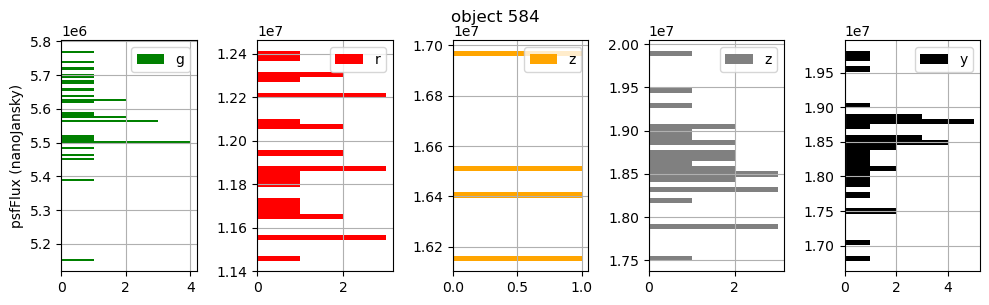

24


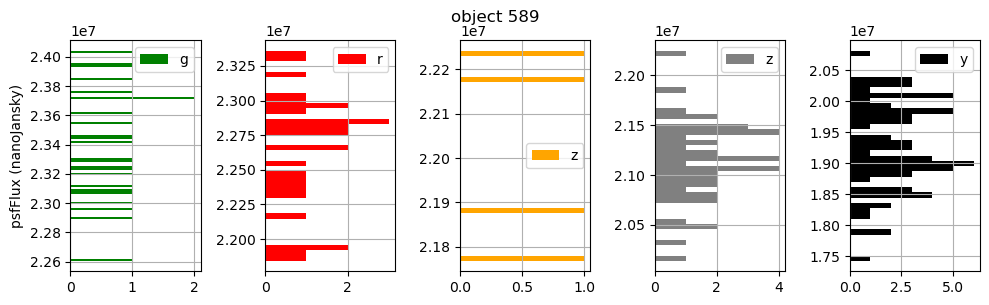

25


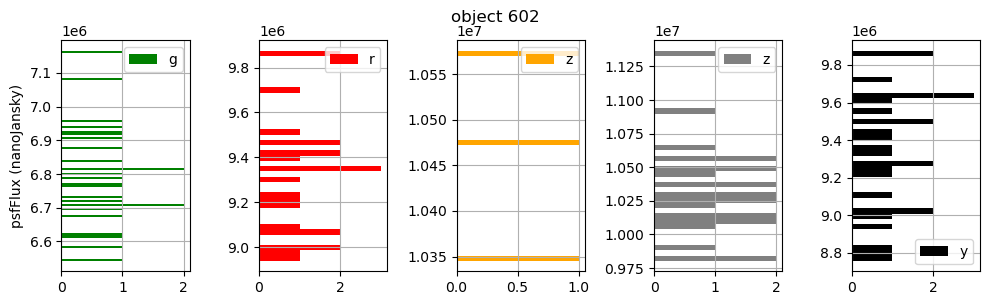

46


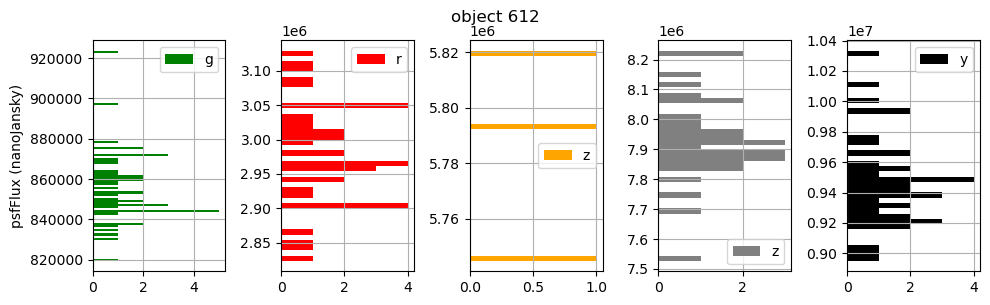

45


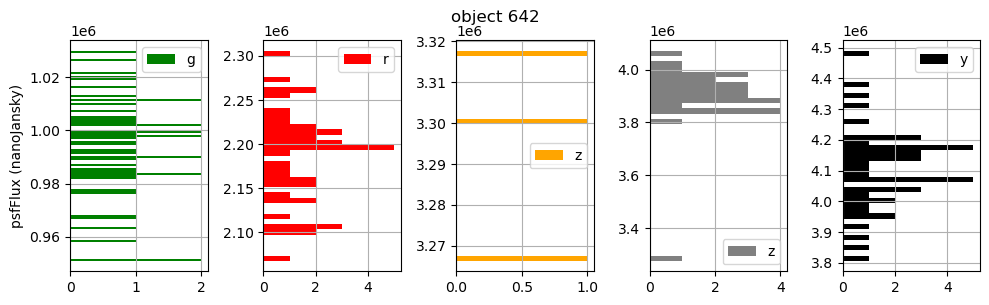

32


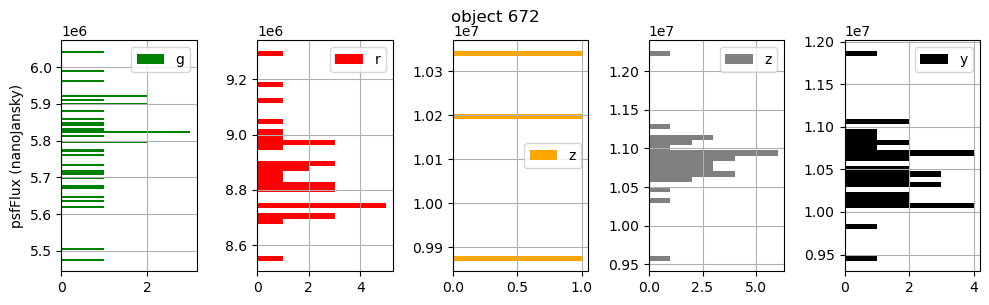

57


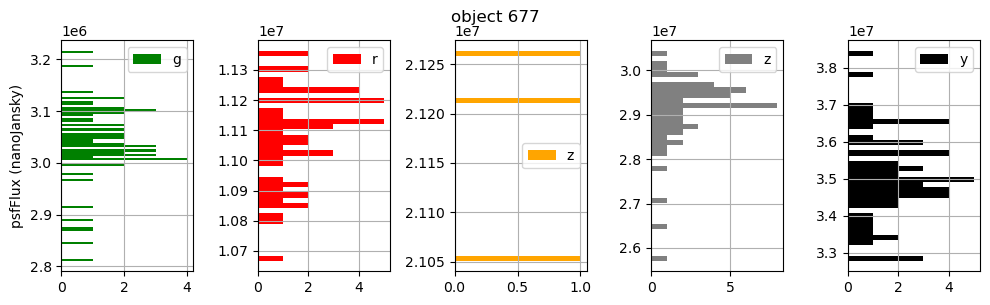

77


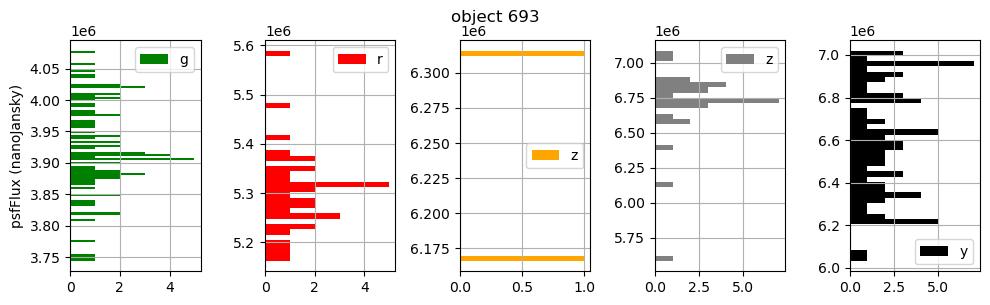

30


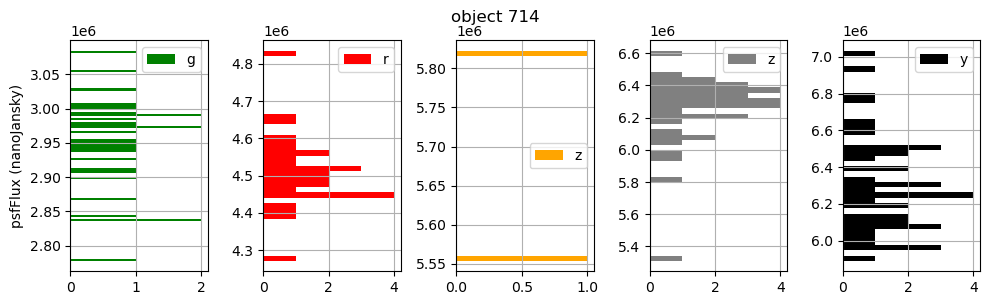

21


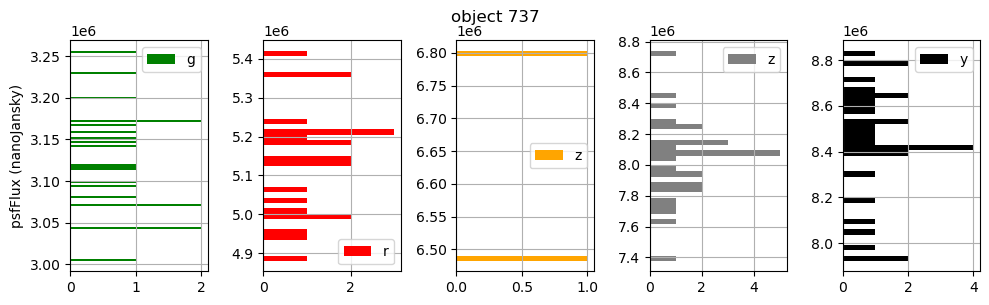

59


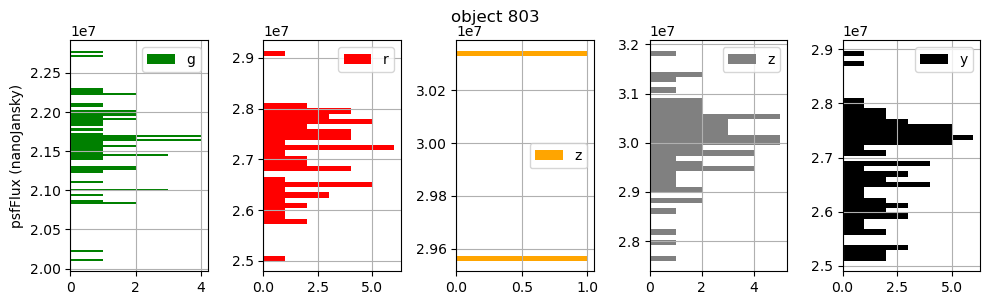

31


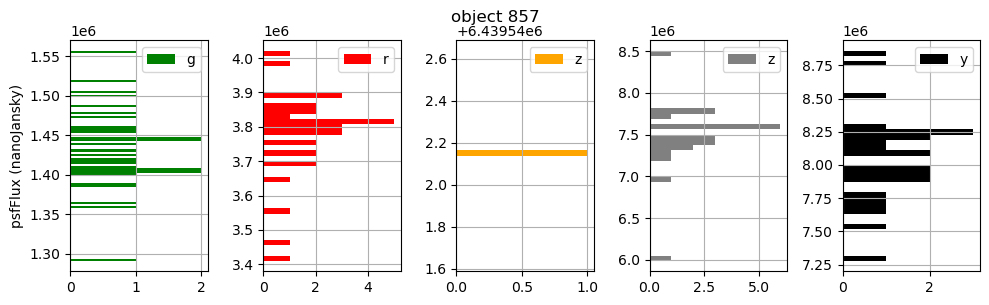

66


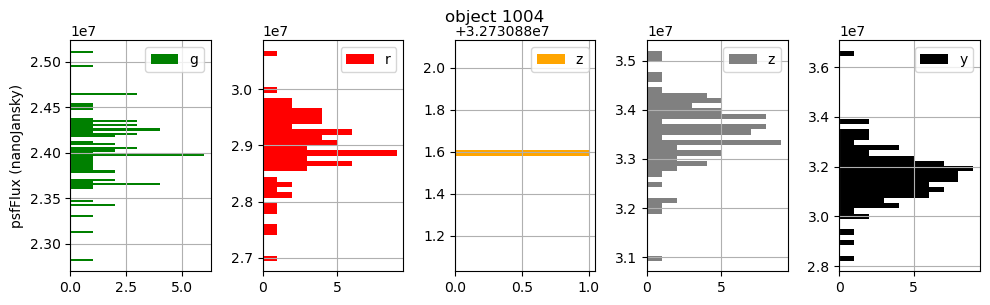

29


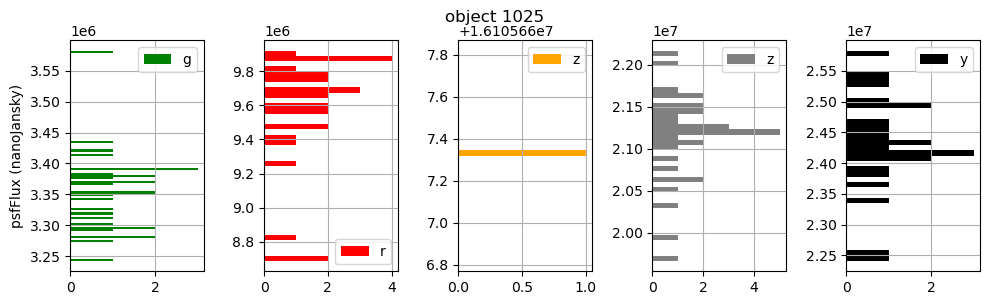

In [55]:
df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()
    
    df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g['psfMag'].median(),
                             isolatedStarSources_sel_r['psfMag'].median(),   
                             isolatedStarSources_sel_i['psfMag'].median(),   
                             isolatedStarSources_sel_z['psfMag'].median(),
                             isolatedStarSources_sel_y['psfMag'].median()]

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()
    for idx,ax in enumerate(axs):
        if idx==0:
            print(len(isolatedStarSources_sel_g["psfFlux"]))
            isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
            ax.legend("g")
            ax.set_ylabel("psfFlux (nanoJansky)")
        elif idx==1:
            isolatedStarSources_sel_r["psfFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
            ax.legend("r")
        elif idx==2:
            isolatedStarSources_sel_i["psfFlux"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
            ax.legend("z")
        elif idx==3:
            isolatedStarSources_sel_z["psfFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
            ax.legend("z")
        elif idx==4:
            isolatedStarSources_sel_y["psfFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
            ax.legend("y")
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    plt.savefig(filename)
    plt.show()

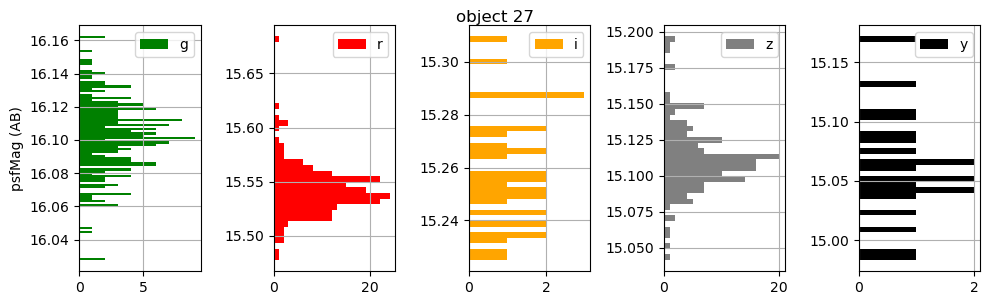

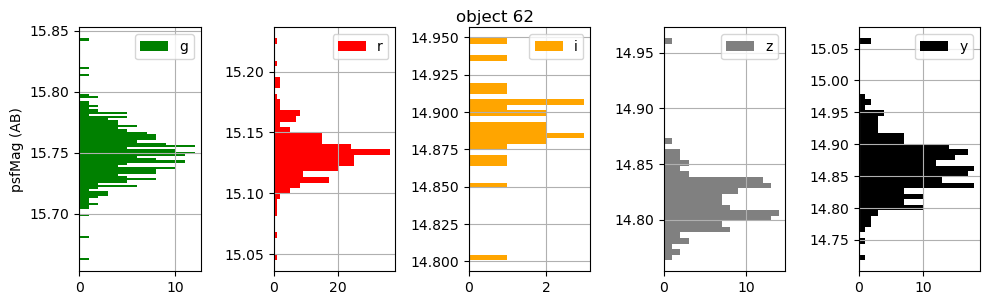

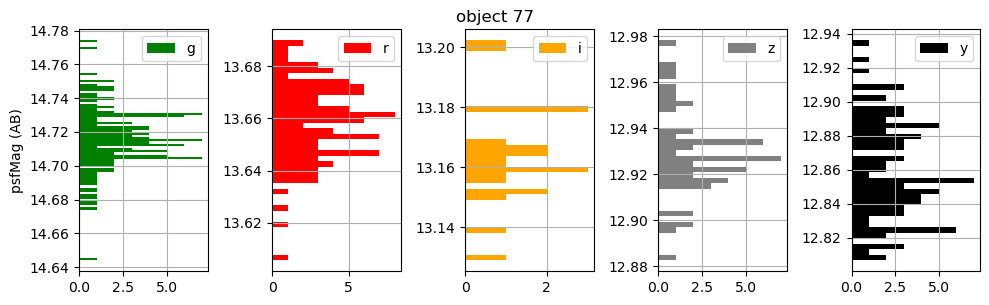

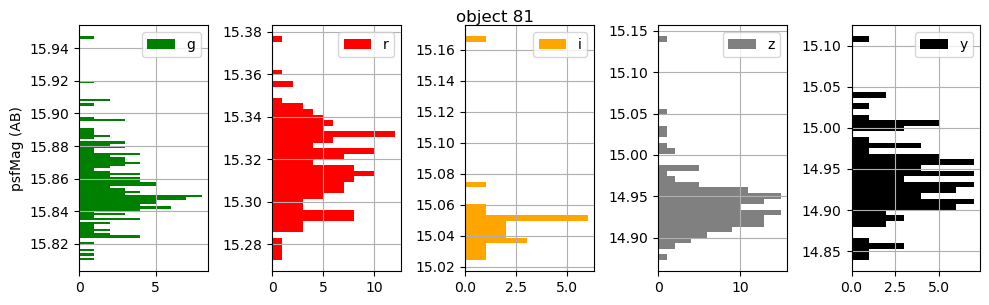

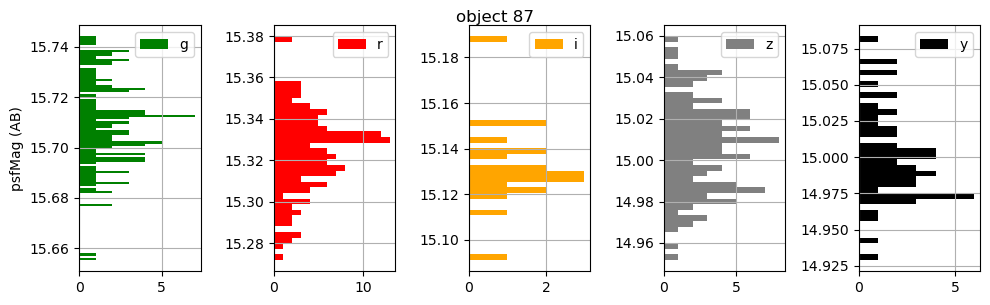

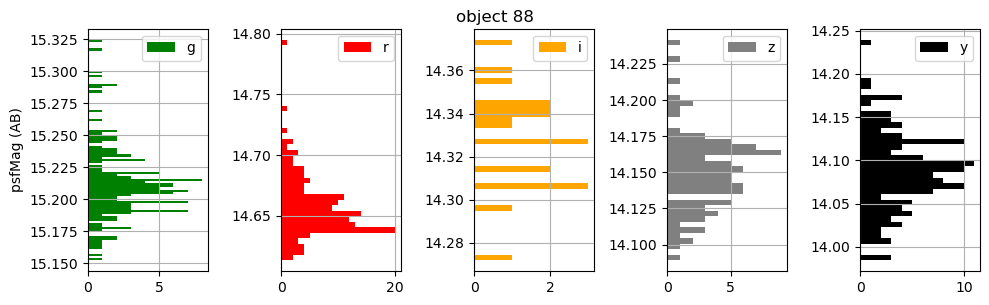

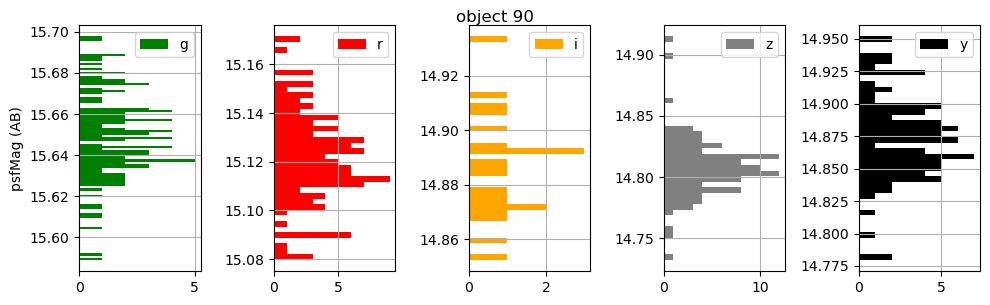

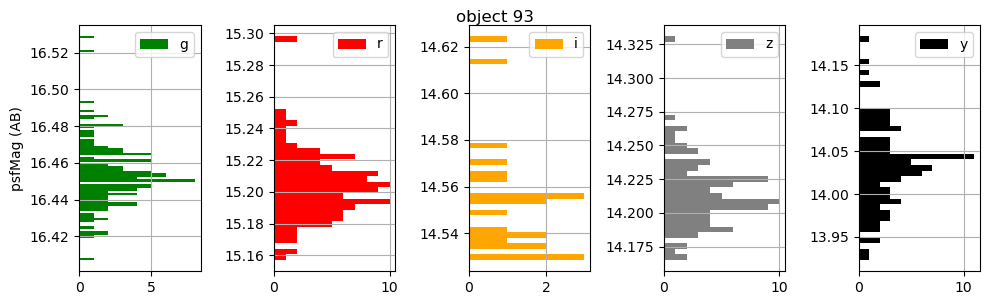

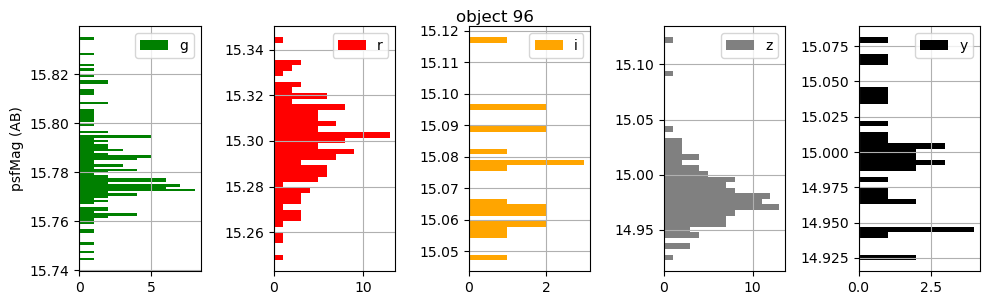

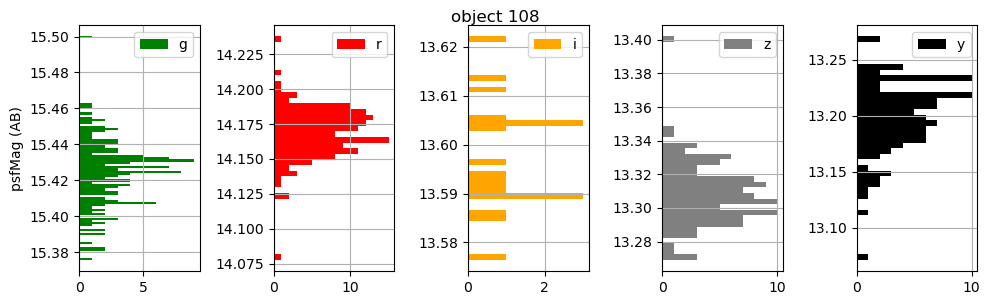

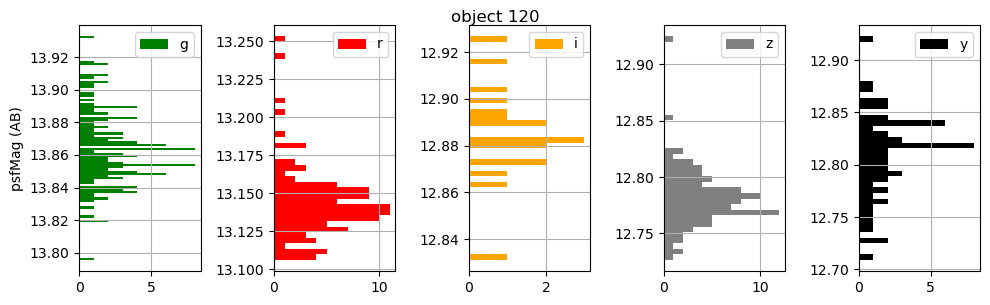

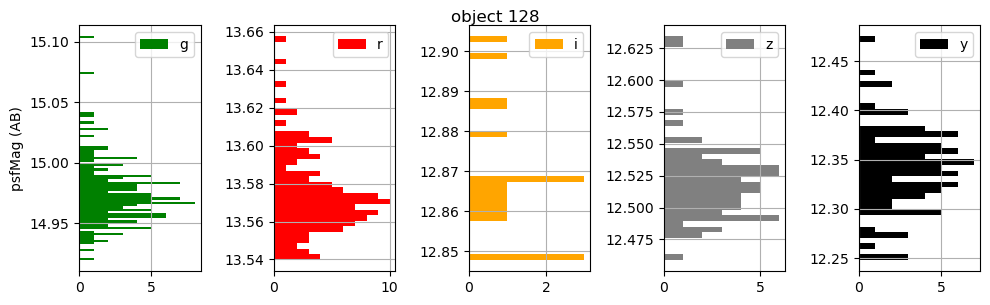

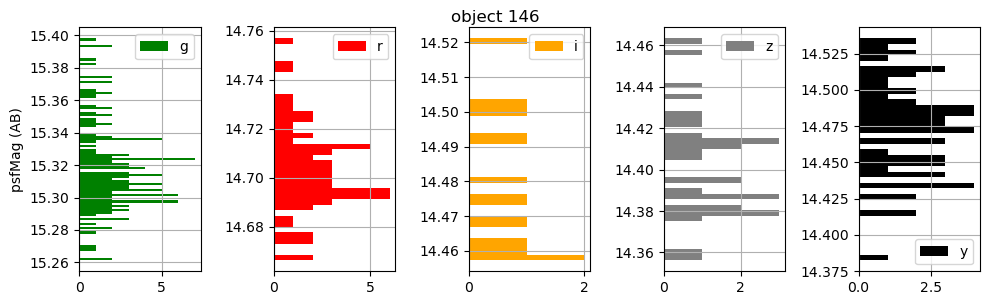

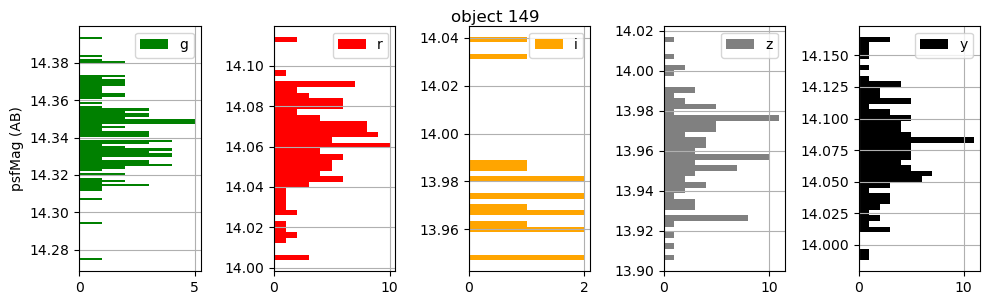

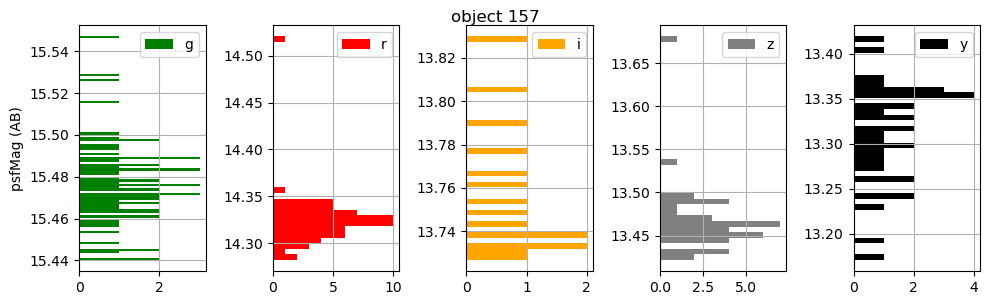

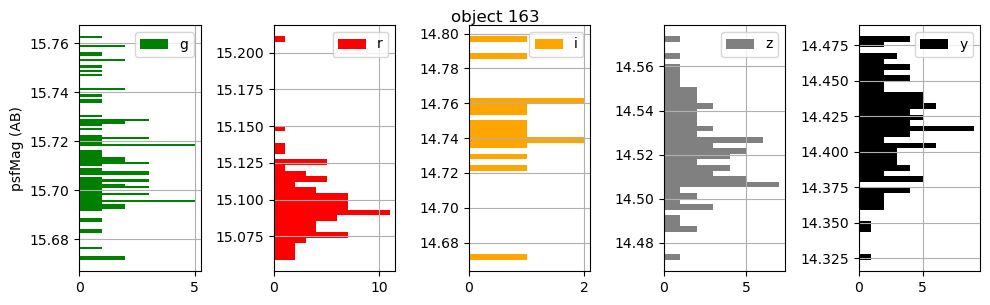

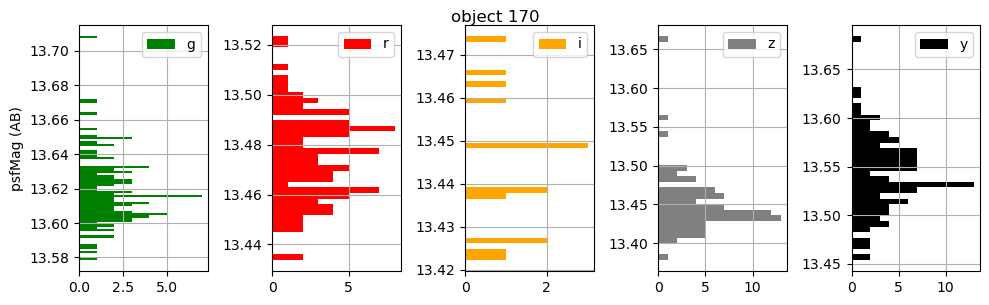

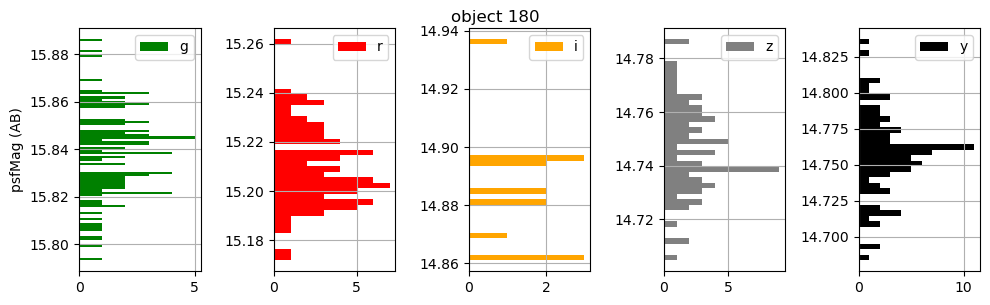

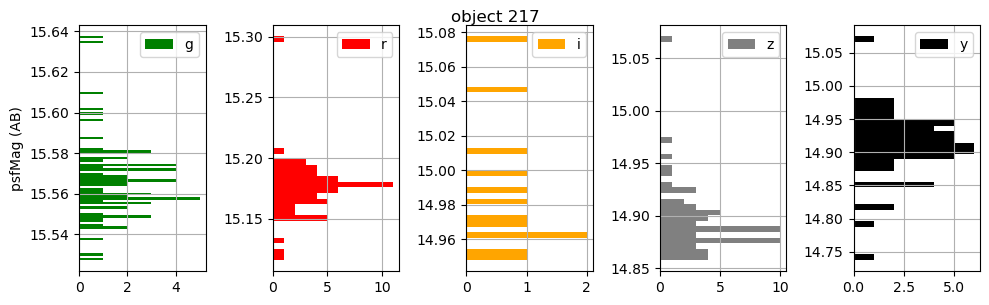

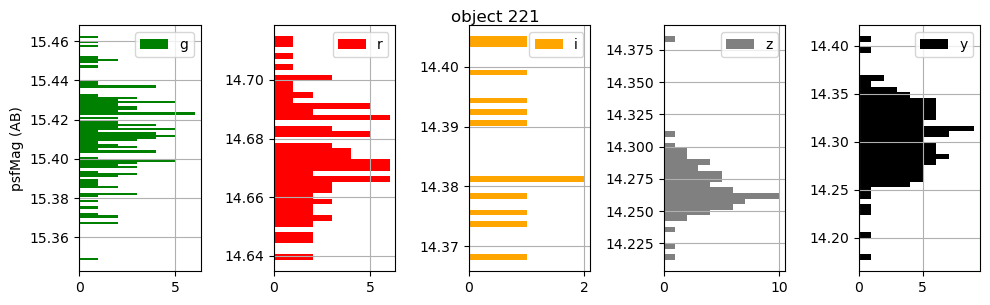

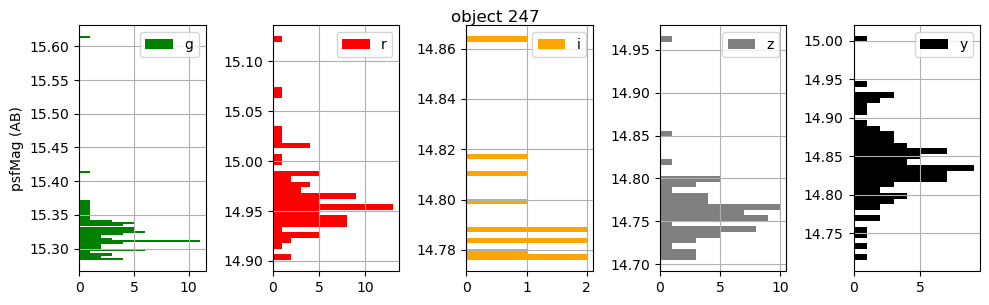

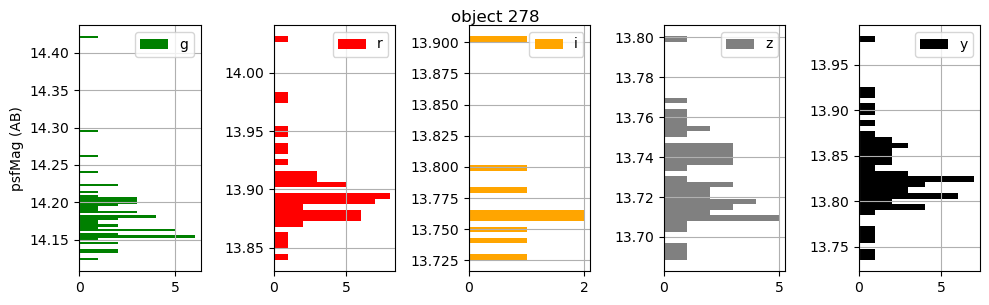

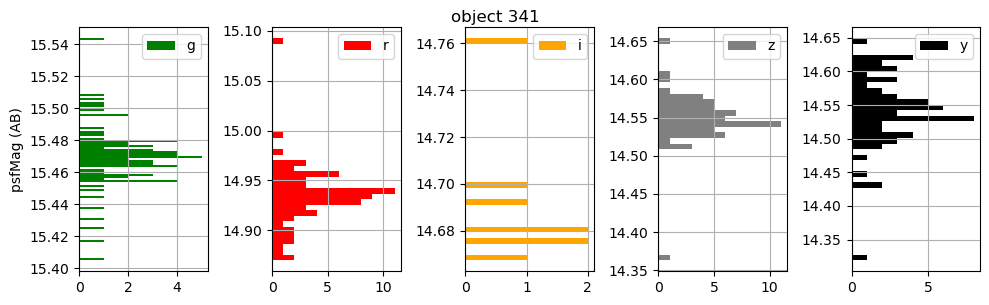

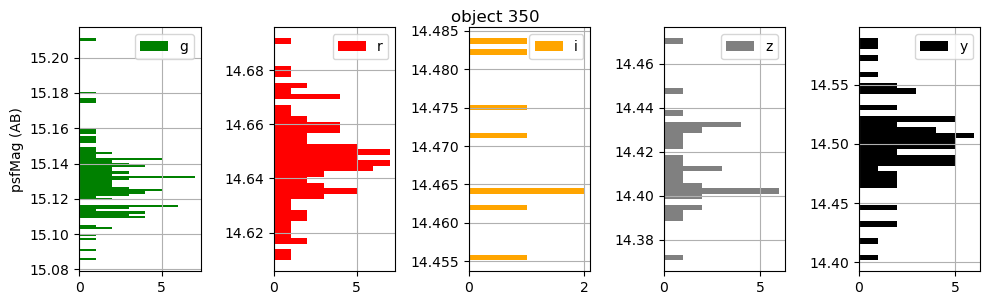

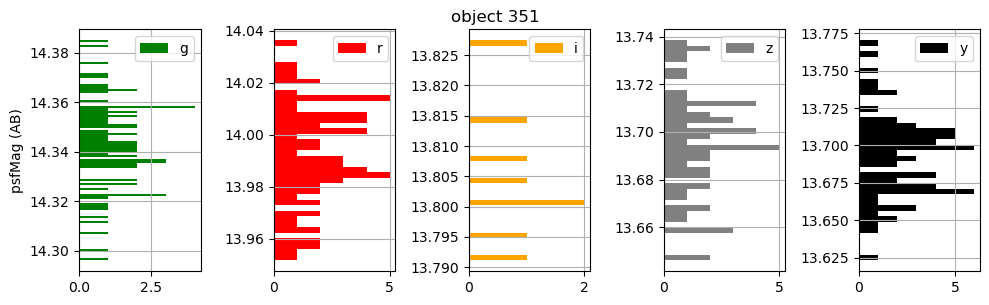

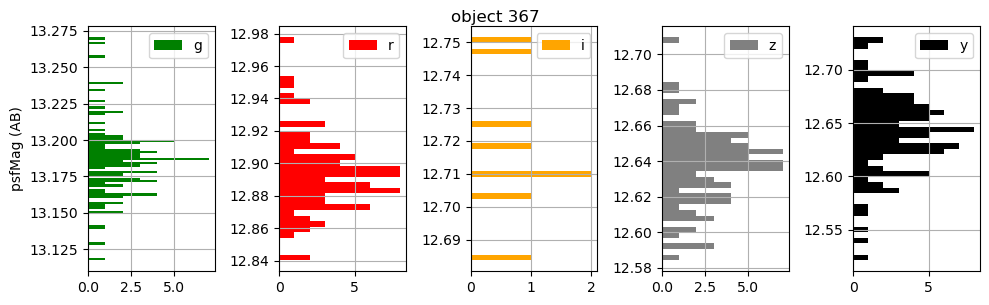

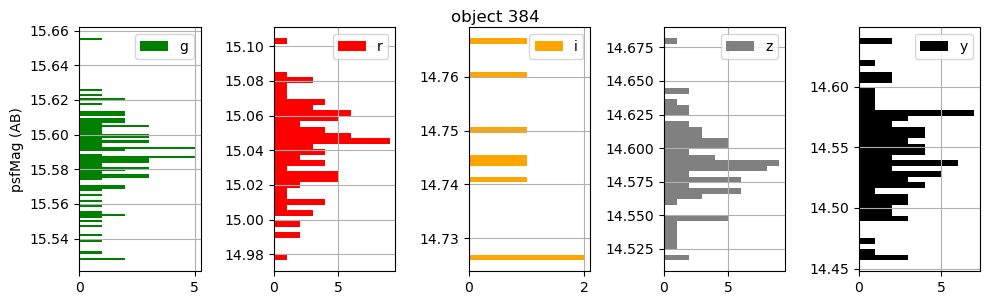

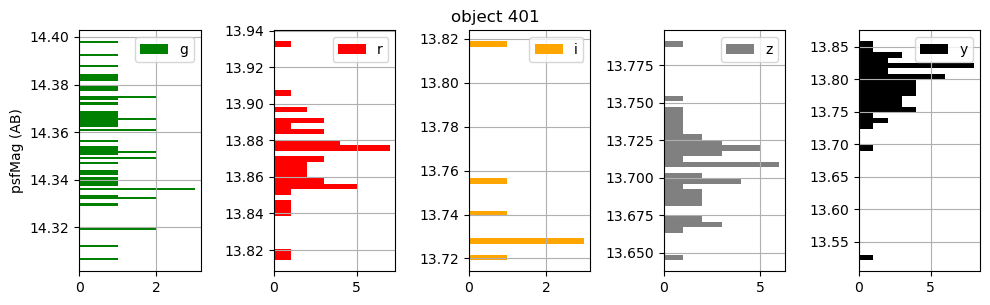

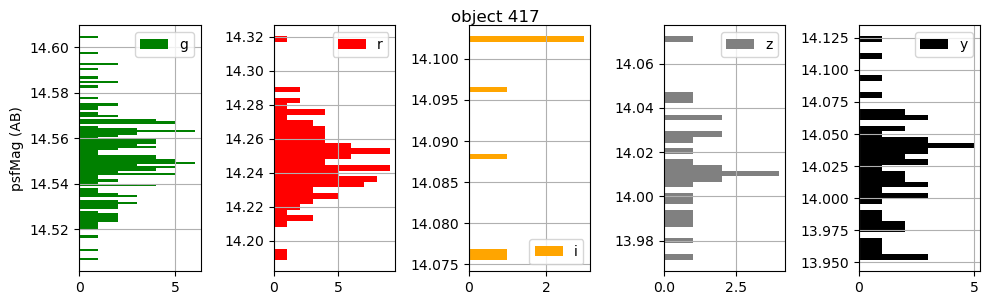

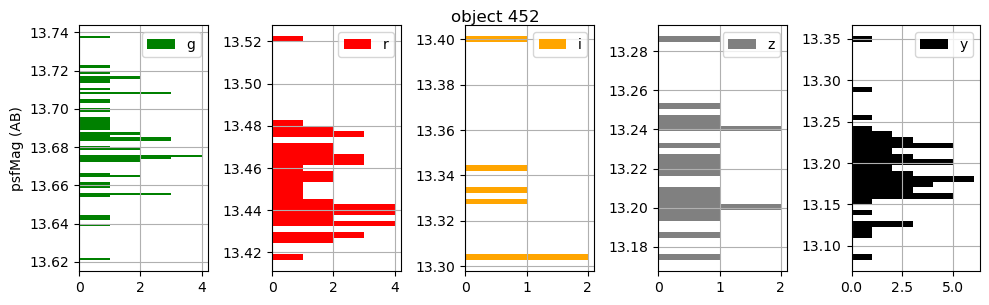

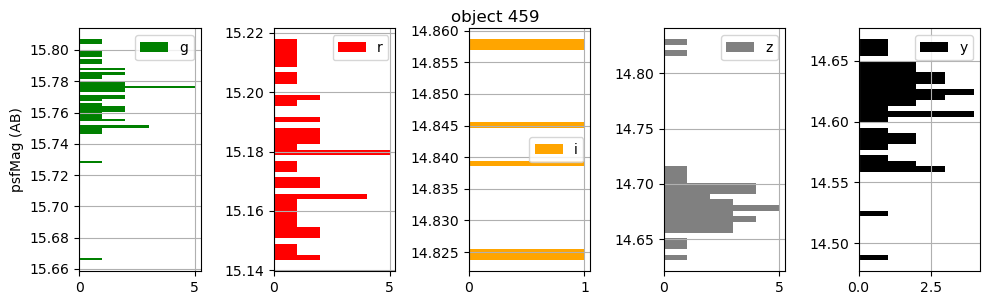

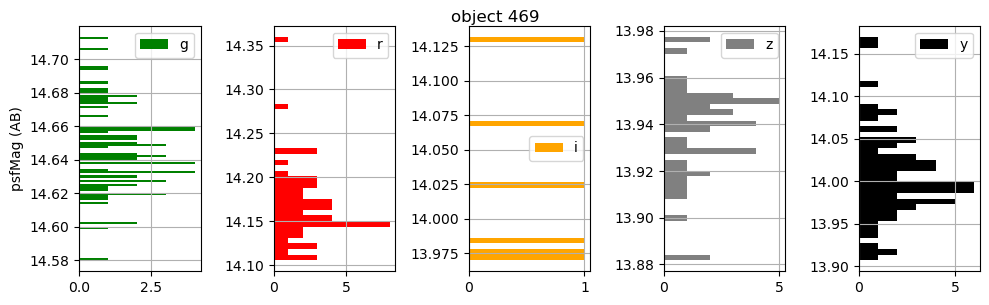

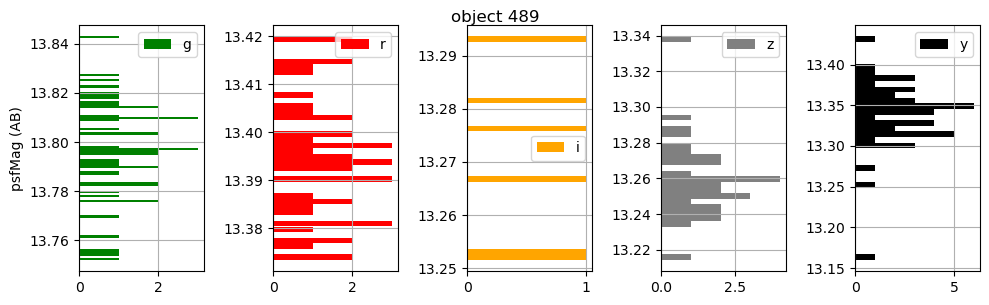

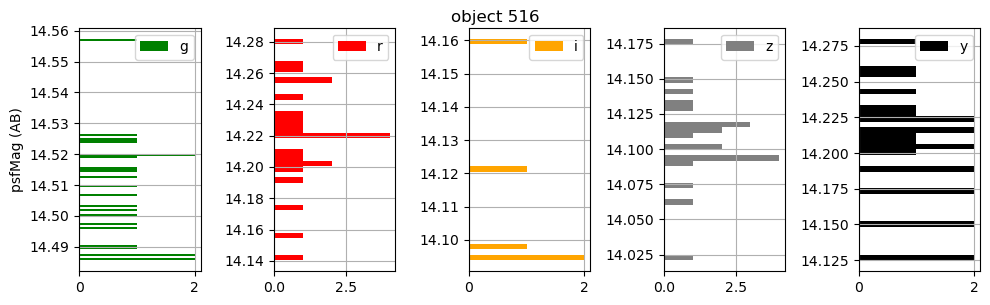

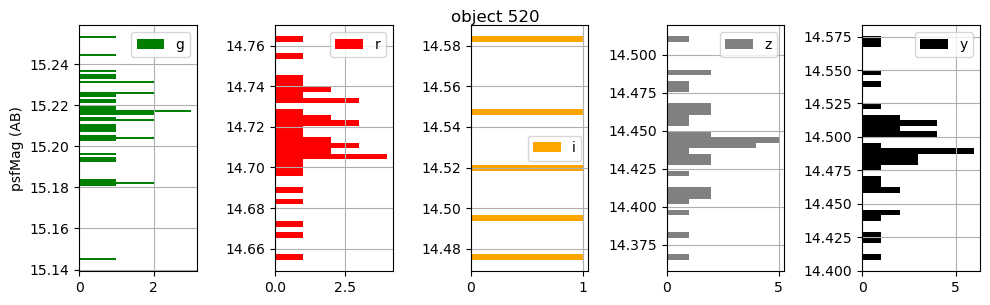

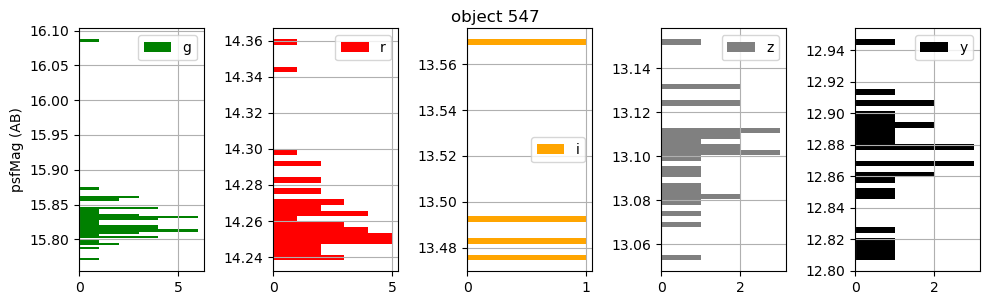

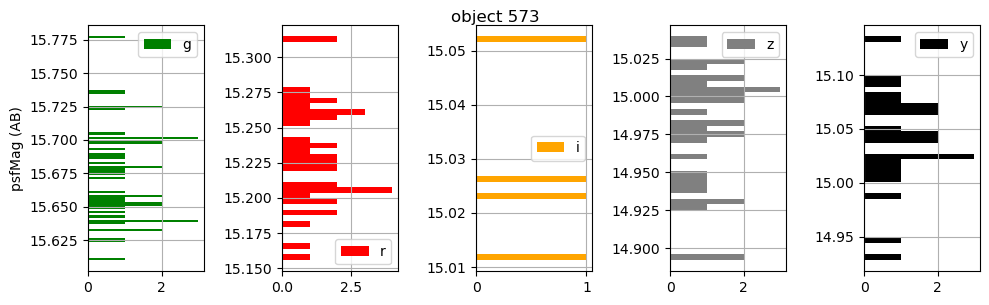

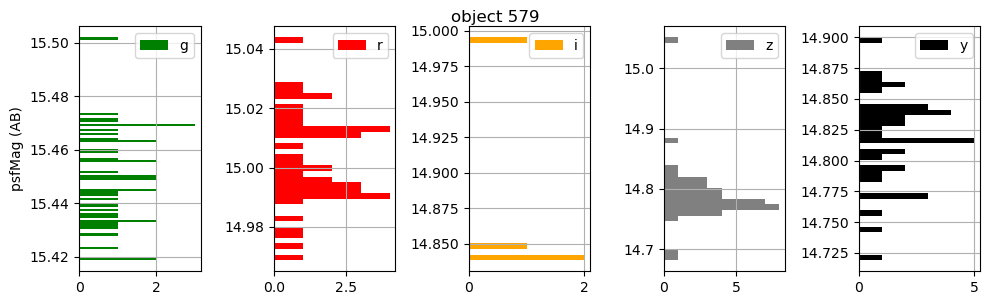

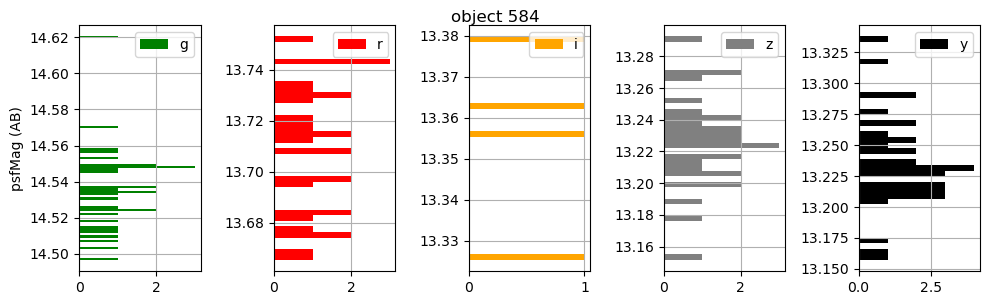

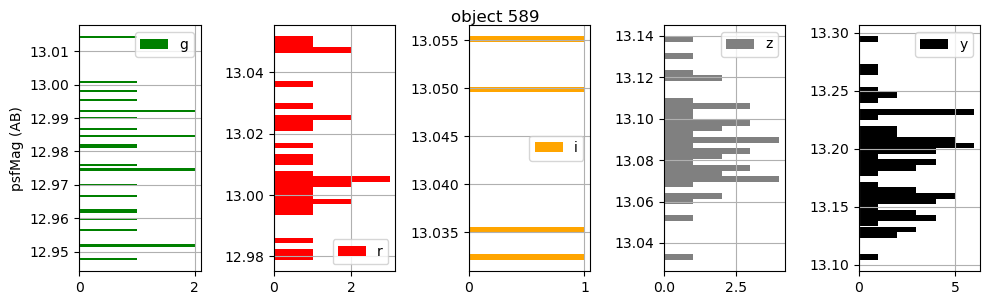

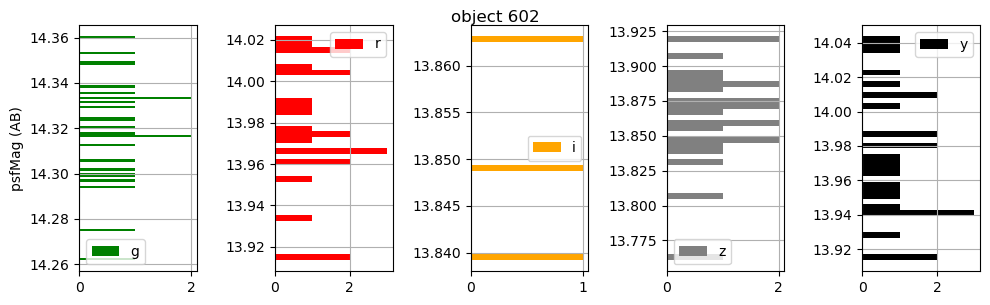

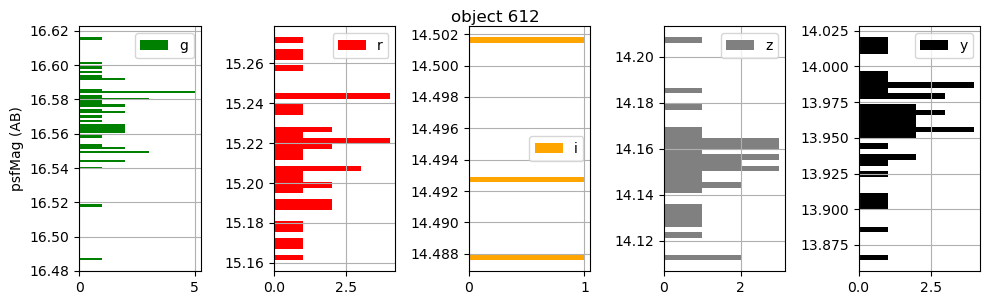

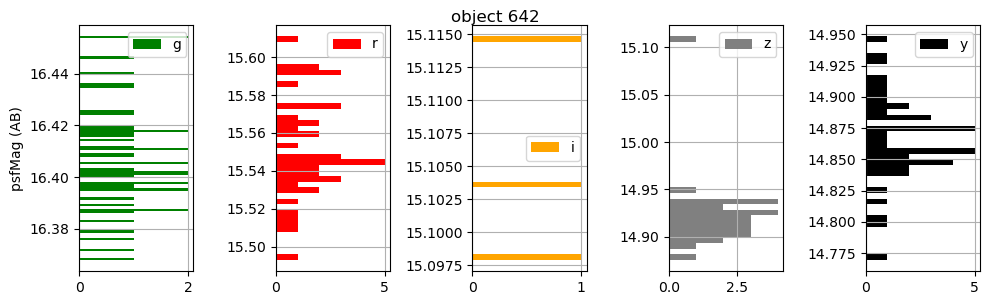

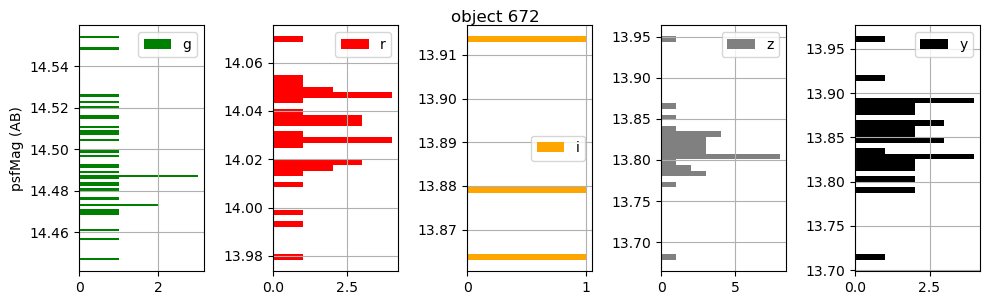

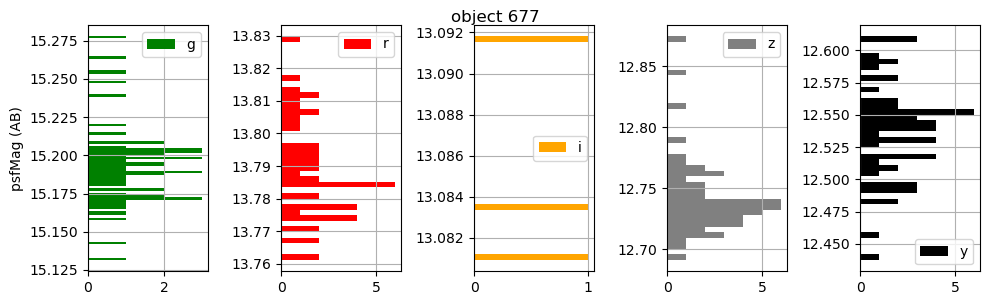

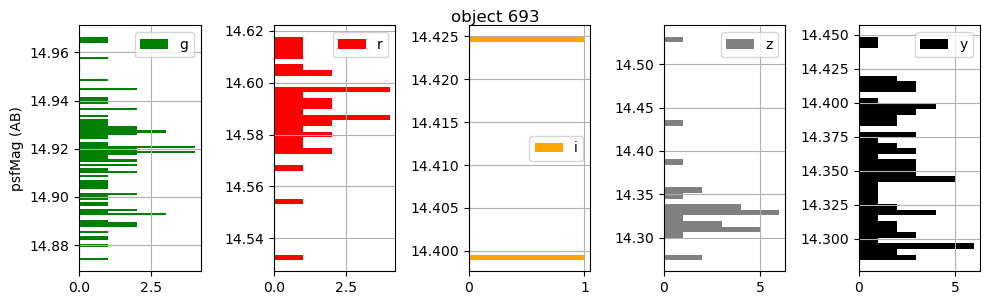

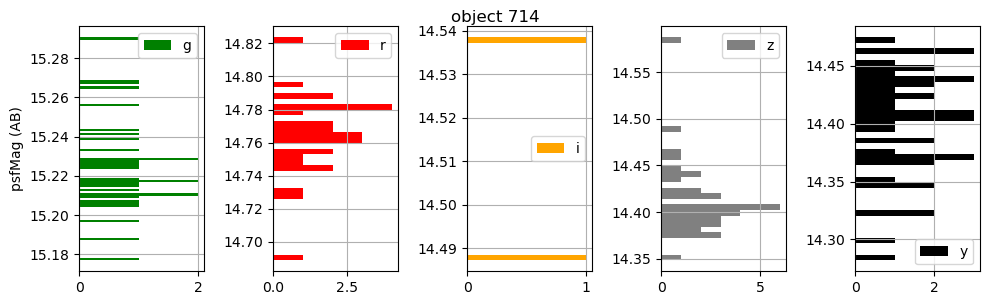

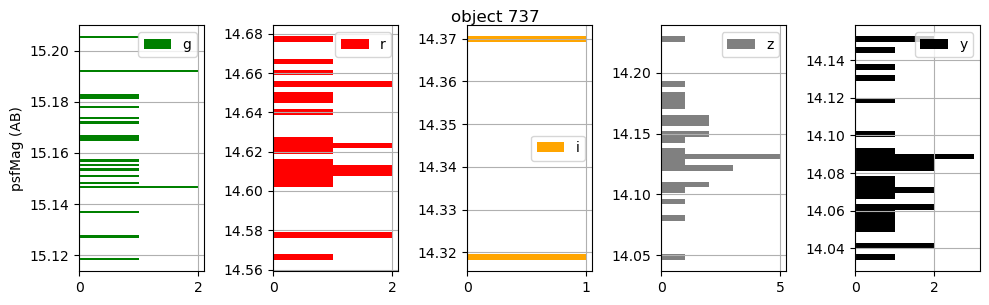

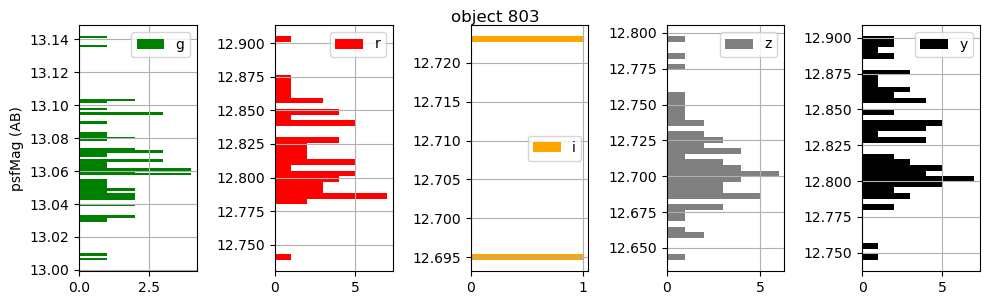

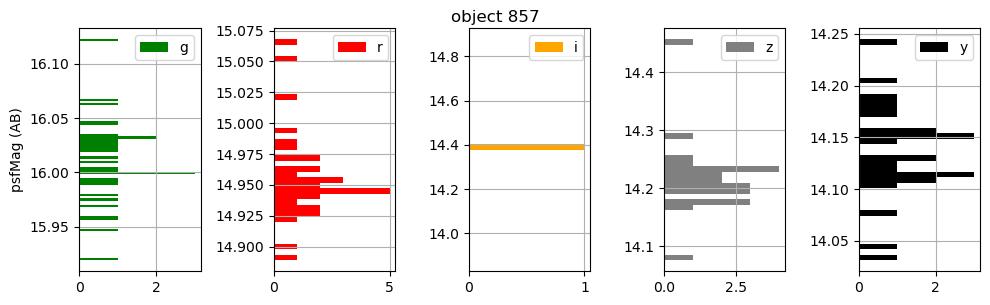

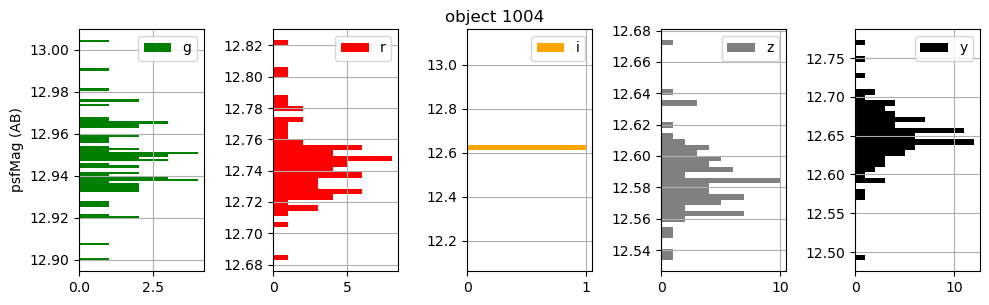

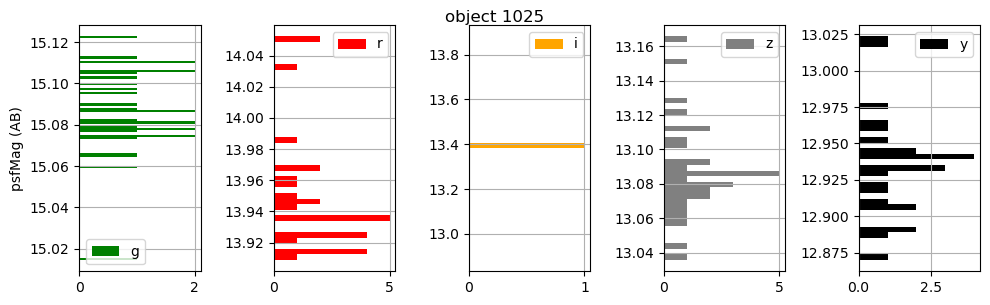

In [56]:
df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()
    
    df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g['psfMag'].median(),
                             isolatedStarSources_sel_r['psfMag'].median(),   
                             isolatedStarSources_sel_i['psfMag'].median(),   
                             isolatedStarSources_sel_z['psfMag'].median(),
                             isolatedStarSources_sel_y['psfMag'].median()]

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()
    for idx,ax in enumerate(axs):
        if idx==0:
           
            isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
            ax.legend("g")
            ax.set_ylabel("psfMag (AB)")
        elif idx==1:
            isolatedStarSources_sel_r["psfMag"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
            ax.legend("r")
        elif idx==2:
            isolatedStarSources_sel_i["psfMag"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
            ax.legend("i")
        elif idx==3:
            isolatedStarSources_sel_z["psfMag"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
            ax.legend("z")
        elif idx==4:
            isolatedStarSources_sel_y["psfMag"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
            ax.legend("y")
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    plt.savefig(filename)
    plt.show()

In [57]:
isolatedStarSources_sel_g['psfMag'].std()

0.021122715902586266

In [64]:
# define the sigmaclip algo
sigclip = SigmaClip(sigma=2, maxiters=None, cenfunc='mean')


df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY','smagG', 'smagR','smagI','smagZ','smagY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    sample_g = isolatedStarSources_sel_g['psfMag'].values
    sample_r = isolatedStarSources_sel_r['psfMag'].values
    sample_i = isolatedStarSources_sel_i['psfMag'].values
    sample_z = isolatedStarSources_sel_z['psfMag'].values
    sample_y = isolatedStarSources_sel_y['psfMag'].values
 
    
    sample_g = sigclip(sample_g, masked=False, copy=False)
    sample_r = sigclip(sample_r, masked=False, copy=False)
    
    sample_z = sigclip(sample_r, masked=False, copy=False)
    sample_y = sigclip(sample_r, masked=False, copy=False)


 
    
    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()
    
    df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             sample_g.mean(),sample_r.mean(),sample_i.mean(),sample_z.mean(),sample_y.mean(),
                             sample_g.std(),sample_r.std(),sample_i.std(),sample_z.std(),sample_y.std()              
                           ]

    icnt +=1

 

In [65]:
df_obj_sed 

idx_obj          ra        dec       magG       magR       magI  \
0      27.0  122.496324 -36.150155  16.102212  15.538969  15.258173   
1      62.0  122.506622 -36.176345  15.749853  15.130541  14.890439   
2      77.0  122.558805 -36.184125  14.715954  13.659001  13.163863   
3      81.0  122.467499 -36.198182  15.853523  15.316697  15.051084   
4      87.0  122.565973 -36.177767  15.710241  15.326746  15.132029   
5      88.0  122.476706 -36.132520  15.205756  14.648065  14.329300   
6      90.0  122.556549 -36.138403  15.649181  15.120959  14.886454   
7      93.0  122.443243 -36.188545  16.451655  15.201996  14.554751   
8      96.0  122.458940 -36.203409  15.778089  15.300628  15.073751   
9     108.0  122.532140 -36.209822  15.425986  14.169494  13.597550   
10    120.0  122.476593 -36.168952  13.859758  13.140340  12.884896   
11    128.0  122.472451 -36.140299  14.968068  13.567917  12.868931   
12    146.0  122.506516 -36.132250  15.308345  14.700912  14.480004   
13    149.0  122.573559 -36.178003  14.341369  14.065502  13.977406   
14    157.0  122.432449 -36.180699  15.476278  14.324021  13.758524   
15    163.0  122.506535 -36.145853  15.708389  15.095696  14.746777   
16    170.0  122.465050 -36.202205  13.614270  13.473606  13.444558   
17    180.0  122.562104 -36.210801  15.839568  15.207271  14.886008   
18    217.0  122.423234 -36.188259  15.563249  15.174671  14.989401   
19    221.0  122.513468 -36.199388  15.413927  14.673326  14.386929   
20    247.0  122.507136 -36.097837  15.316509  14.955090  14.796953   
21    278.0  122.549264 -36.103294  14.174126  13.891127  13.774350   
22    341.0  122.412282 -36.186191  15.468843  14.937711  14.691850   
23    350.0  122.567971 -36.150387  15.128042  14.647110  14.469754   
24    351.0  122.580118 -36.150032  14.344297  13.992057  13.805180   
25    367.0  122.495354 -36.129916  13.184434  12.890953  12.718718   
26    384.0  122.584368 -36.156101  15.590697  15.043995  14.744951   
27    401.0  122.553482 -36.250531  14.356225  13.871614  13.745502   
28    417.0  122.515903 -36.156007  14.552170  14.245042  14.092011   
29    452.0  122.467915 -36.243180  13.685633  13.451303  13.335543   
30    459.0  122.436210 -36.096039  15.769591  15.176058  14.841399   
31    469.0  122.488426 -36.095863  14.645772  14.156860  14.026185   
32    489.0  122.557611 -36.237342  13.799951  13.392938  13.270403   
33    516.0  122.613745 -36.208323  14.505418  14.225411  14.113580   
34    520.0  122.603653 -36.202046  15.215559  14.719024  14.524767   
35    547.0  122.445780 -36.109089  15.822242  14.254528  13.505474   
36    573.0  122.515549 -36.080384  15.668080  15.230047  15.028332   
37    579.0  122.441628 -36.246919  15.448811  15.002876  14.880223   
38    584.0  122.603451 -36.117018  14.532893  13.708997  13.355938   
39    589.0  122.479650 -36.161170  12.975709  13.012721  13.043159   
40    602.0  122.614686 -36.183510  14.323548  13.985917  13.850576   
41    612.0  122.458964 -36.086390  16.571292  15.211987  14.494001   
42    642.0  122.451151 -36.083081  16.402147  15.551572  15.105462   
43    672.0  122.428737 -36.252170  14.491025  14.033556  13.885378   
44    677.0  122.439570 -36.158085  15.188488  13.788004  13.085413   
45    693.0  122.447685 -36.220996  14.914644  14.589000  14.411945   
46    714.0  122.406515 -36.207939  15.220067  14.767729  14.512856   
47    737.0  122.611126 -36.182901  15.164715  14.626458  14.344392   
48    803.0  122.526057 -36.119801  13.060201  12.814008  12.709031   
49    857.0  122.395846 -36.219595  16.011007  14.944347  14.377863   
50   1004.0  122.493071 -36.220900  12.947119  12.739857  12.612606   
51   1025.0  122.448886 -36.103366  15.087678  13.934873  13.382553   

         magZ       magY     smagG     smagR     smagI     smagZ     smagY  
0   15.538969  15.538969  0.013298  0.013209  0.020905  0.013209  0.013209  
1   15.130541  15.130541  0.015063  0.010429  0.028146  0.010429  0.010429  
2   13.65

In [96]:
dict_photores = {}
Flist = ["G","R","I","Z","Y"]
for f in Flist :
    label = f"smag{f}"
    smean = df_obj_sed[label].values.mean() 
    smmag = smean*1000. 
    title = "{} = {:.3f} mmag".format(label,smmag)

    d = dict(sig=smean,title=title)
    dict_photores[f] = d

In [97]:
dict_photores

{'G': {'sig': 0.014320566112955025, 'title': 'smagG = 14.321 mmag'},
 'R': {'sig': 0.015066541605920096, 'title': 'smagR = 15.067 mmag'},
 'I': {'sig': 0.020965647402209544, 'title': 'smagI = 20.966 mmag'},
 'Z': {'sig': 0.015066541605920096, 'title': 'smagZ = 15.067 mmag'},
 'Y': {'sig': 0.015066541605920096, 'title': 'smagY = 15.067 mmag'}}

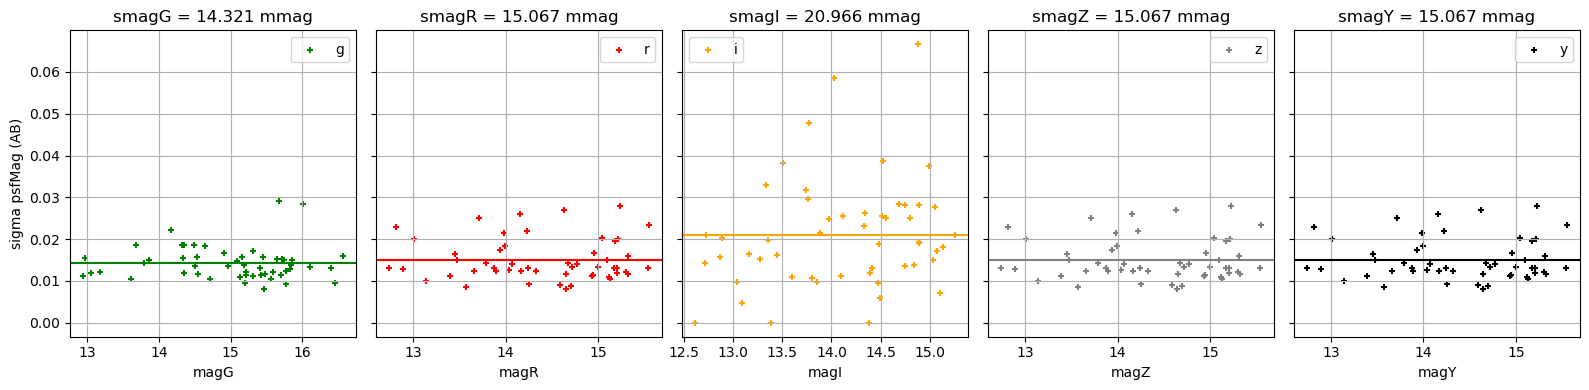

In [98]:
fig,axes = plt.subplots(1,5,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.plot.scatter( x="magG", y="smagG",marker= "+", color="g",ax=ax)
            ax.legend("g")
            ax.set_ylabel("sigma psfMag (AB)")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="g")
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.plot.scatter( x="magR", y="smagR",marker= "+", color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="r")
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.plot.scatter( x="magI", y="smagI",marker= "+", color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="orange")
            ax.set_title(dict_photores[f]['title'])
    elif idx==3:
            df_obj_sed.plot.scatter( x="magZ", y="smagZ",marker= "+", color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="grey")
            ax.set_title(dict_photores[f]['title'])
    elif idx==4:
            df_obj_sed.plot.scatter( x="magY", y="smagY",marker= "+", color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="k")
            ax.set_title(dict_photores[f]['title'])
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.show()

In [ ]:
obj_index_sel = 803
cut = dataJoined_subset["obj_index"] == obj_index_sel 

In [ ]:
dataJoined_subset_sel = dataJoined[cut]

In [ ]:
dataJoined_subset_sel.columns

In [ ]:
data_obj = dataJoined_subset_sel[["obj_index","band","psfMag","expMidptMjd","zeroPoint","visit","airmass"]]
data_obj_g = data_obj[data_obj['band'] == "g"]

In [ ]:
data_obj_g

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
data_obj_g.plot.scatter(x="expMidptMjd",y="psfMag",ax=ax,color='g')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
data_obj_g.plot.scatter(x="expMidptMjd",y="airmass",ax=ax,color='g')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
data_obj_g.plot.scatter(x="expMidptMjd",y="zeroPoint",ax=ax,color='g')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
data_obj_g.plot.scatter(x="airmass",y="psfMag",ax=ax,color='g')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
data_obj_g.plot.scatter(x="airmass",y="zeroPoint",ax=ax,color='g')

In [ ]:
 isolatedStarSources_sel_g["psfFlux"].hist(bins=40,facecolor="g")

In [ ]:
isolatedStarSources_sel_g["psfFlux"]

In [ ]:
#isolatedStarSources_sel 
isolatedStarSources_sel_g

In [ ]:
#diagramme magnitude Z vs couleur (Z-Y) et voir l’étalement de
#la séquence principale, et peut-être la branche des géantes rouges.

In [ ]:
Nobj = len(df_obj_sed)
import seaborn as sns
from matplotlib.colors import ListedColormap
color_palette = sns.color_palette("hls", Nobj)

In [ ]:
color_palette

In [ ]:
mpl_colors = ListedColormap(sns.color_palette(color_palette).as_hex())

In [ ]:
mpl_colors.colors

In [ ]:
df_obj_sed["Z-Y"] = df_obj_sed["magZ"] - df_obj_sed["magY"] 
df_obj_sed["G-R"] = df_obj_sed["magG"] - df_obj_sed["magR"] 

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

ax=axs[0]
df_obj_sed.plot.scatter(y="magR",x="G-R",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[1]
df_obj_sed.plot.scatter(y="magZ",x="Z-Y",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()

plt.suptitle(f"isolated sources-objects in tract {tract}")

In [ ]:
df_obj_sed.to_csv(f"isolated_source_objects_tract{tract}.csv")

In [ ]:
assert False

In [ ]:
count_source_visit.hist(x="obj_index")

In [ ]:
count_sources = dataJoined.groupby(by="obj_index").count()["psfFlux"]

In [ ]:
count_source.hist(bins=100,range=(0,100))

In [ ]:
assert False

## Plot the per object source 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
dataJoined.columns

In [ ]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()
if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-20, 20)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
all_nightObs = dataJoined["nightObs"].unique() 
all_X = []
all_Y1 = []
all_EY1 = []
all_Y2 = []
all_EY2 = []
for night in all_nightObs:
    cut = dataJoined["nightObs"] == night
    df_sel = dataJoined[cut]
    pwv = df_sel["PWV"].mean()
    Y1 = df_sel["psfMagDiffMmag"].mean()
    EY1= df_sel["psfMagDiffMmag"].std()
    Y2 = df_sel["psfMagDiffChi"].mean()
    EY2 = df_sel["psfMagDiffChi"].std()
    all_X.append(pwv)
    all_Y1.append(Y1)
    all_EY1.append(EY1)
    all_Y2.append(Y2)
    all_EY2.append(EY2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)
ax1.errorbar(all_X,all_Y1,yerr=all_EY1,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax1.set_ylim(-50, 50)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")
ax2.errorbar(all_X,all_Y2,yerr=all_EY2,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)     

In [ ]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} : {} {}sec".format(iObj,visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

In [ ]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

In [ ]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [ ]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax.set_xlabel("MJD")
ax.set_ylabel("airmass")
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax2.set_ylabel("zero-point (mag)")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
suptitle = f"Airmass and zero point for tract {tract} in band {band} (AUXTEL)"
ax.set_title(suptitle)
#ax2.set_ylim(27,28.5)

## Difference vs PWV

## Save the sources

In [ ]:
dataJoined.to_csv(fullname_file_output_selectedsources)